In [ ]:
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

#読み込み

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install xgboost
!pip install optuna
!pip install lightgbm
!pip install catboost

     |████████████████████████████████| 308 kB 31.2 MB/s 
     |████████████████████████████████| 209 kB 78.2 MB/s 
     |████████████████████████████████| 80 kB 11.6 MB/s 
     |████████████████████████████████| 75 kB 5.5 MB/s 
     |████████████████████████████████| 149 kB 81.0 MB/s 
     |████████████████████████████████| 112 kB 82.3 MB/s 
     |████████████████████████████████| 49 kB 7.9 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=602599b0e17abd5df0736d33a526f4d639f20a3c0e1cae5f684a7649b363a38a
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip
     |████████████████████████████████| 76.1 MB 1.3 MB/s 


In [ ]:
# データ操作
import numpy as np
import pandas as pd

# データ可視化
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#日付の扱い
import datetime
from datetime import timedelta

#正規化とか
import scipy.stats
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

# 交差検証
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import KFold, cross_val_score, cross_validate

#誤差確認
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error

#重回帰
from sklearn.linear_model import LinearRegression

#ランダムフォレスト
from sklearn import datasets
from sklearn.ensemble import RandomForestRegressor

#DNN
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.pipeline import Pipeline

#XGBoost
import xgboost as xgb

#LightGBM
import lightgbm as lgb

#CatBoost
from catboost import CatBoost
from catboost import Pool

#パラメータチューニング
import optuna

#警告無視
import warnings
warnings.filterwarnings('ignore')

In [ ]:
train=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SIGNATE/minpaku_price/train.csv")
test=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SIGNATE/minpaku_price/test.csv")

In [ ]:
# 定数の定義
SEED = 2019

In [ ]:
train.shape

(55583, 29)

In [ ]:
train.columns

Index(['id', 'accommodates', 'amenities', 'bathrooms', 'bed_type', 'bedrooms',
       'beds', 'cancellation_policy', 'city', 'cleaning_fee', 'description',
       'first_review', 'host_has_profile_pic', 'host_identity_verified',
       'host_response_rate', 'host_since', 'instant_bookable', 'last_review',
       'latitude', 'longitude', 'name', 'neighbourhood', 'number_of_reviews',
       'property_type', 'review_scores_rating', 'room_type', 'thumbnail_url',
       'zipcode', 'y'],
      dtype='object')

In [ ]:
test.shape

(18528, 28)

In [ ]:
test.columns

Index(['id', 'accommodates', 'amenities', 'bathrooms', 'bed_type', 'bedrooms',
       'beds', 'cancellation_policy', 'city', 'cleaning_fee', 'description',
       'first_review', 'host_has_profile_pic', 'host_identity_verified',
       'host_response_rate', 'host_since', 'instant_bookable', 'last_review',
       'latitude', 'longitude', 'name', 'neighbourhood', 'number_of_reviews',
       'property_type', 'review_scores_rating', 'room_type', 'thumbnail_url',
       'zipcode'],
      dtype='object')

#前処理

In [ ]:
#欠損値処理のために一旦統合
#TrainFlagという列を新たに作り、訓練データにはTrue、テストデータにはFalseとしておく。
train["TrainFlag"] = True
test["TrainFlag"] = False

#訓練データとテストデータを結合する
alldata = train.append(test)

#目的変数を先頭コラムに
cols=alldata.columns.tolist()
cols=cols[-2:]+cols[:-2]

alldata =  alldata[cols] 
alldata

,y,TrainFlag,id,accommodates,amenities,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,description,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,property_type,review_scores_rating,room_type,thumbnail_url,zipcode
0,138.0,True,0,6,"{TV,""Wireless Internet"",Kitchen,""Free parking ...",2.0,Real Bed,1.0,4.0,flexible,LA,t,My place is meant for family and a few friends...,2016-07-27,t,f,NaN,2016-07-13,f,2016-07-27,33.788931,-118.154761,The Penthouse,NaN,1,Apartment,60.0,Private room,NaN,90804
1,42.0,True,1,2,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",1.0,Real Bed,1.0,1.0,strict,DC,t,This is a new listing for a lovely guest bedro...,2016-09-12,t,t,100%,2015-12-30,f,2017-03-31,38.934810,-76.978190,Guest Bedroom in Brookland,Brookland,9,House,100.0,Private room,https://a0.muscache.com/im/pictures/e4d8b51f-6...,20018
2,65.0,True,2,2,"{TV,Internet,""Wireless Internet"",Kitchen,""Indo...",2.0,Real Bed,1.0,1.0,strict,NYC,t,We're looking forward to your stay at our apt....,2016-06-15,t,f,100%,2016-05-21,t,2017-08-13,40.695118,-73.926240,Clean Modern Room in Lux Apt 1 Block From J Train,Bushwick,27,Apartment,83.0,Private room,https://a0.muscache.com/im/pictures/5ffecc9b-d...,NaN
3,166.0,True,3,2,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",1.0,Real Bed,1.0,1.0,strict,SF,t,BEST CITY VIEWS - - ROOF DECK W/ BBQ & WiFi - ...,2014-03-15,t,t,100%,2012-06-19,t,2017-09-03,37.796728,-122.411906,BEST views + reviews! 5/5 stars*****,Nob Hill,38,Apartment,95.0,Private room,NaN,94133
4,165.0,True,4,2,"{TV,Internet,""Wireless Internet"",""Air conditio...",1.0,Real Bed,1.0,1.0,strict,NYC,t,Charming Apartment on the upper west side of M...,2015-08-05,t,t,100%,2015-03-25,f,2017-09-10,40.785050,-73.974691,Charming 1-bedroom - UWS Manhattan,Upper West Side,5,Apartment,100.0,Entire home/apt,https://a0.muscache.com/im/pictures/92879730/5...,10024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18523,NaN,False,18523,4,"{TV,Internet,""Wireless Internet"",""Air conditio...",1.0,Real Bed,2.0,2.0,strict,NYC,t,"The Greenhouse, located on Green Street, is a ...",NaN,t,t,100%,2009-11-16,f,NaN,40.734555,-73.954892,Spacious 2BR Greenpoint Getaway,Greenpoint,0,Apartment,NaN,Entire home/apt,https://a0.muscache.com/im/pictures/57338613/6...,11222
18524,NaN,False,18524,2,"{TV,""Wireless Internet"",""Air conditioning"",Kit...",1.0,Real Bed,2.0,1.0,flexible,Chicago,f,"Two bedroom, one bathroom with large dining/li...",2017-01-16,t,f,100%,2017-01-08,f,2017-04-11,41.945939,-87.672018,Walk up Apartment in Lakeview/Wrigleyville,Lakeview,9,Apartment,90.0,Entire home/apt,NaN,60657
18525,NaN,False,18525,5,"{TV,""Wireless Internet"",""Air conditioning"",Kit...",1.5,Real Bed,2.0,2.0,flexible,Chicago,t,Happy Holidays! If you're looking for a big op...,NaN,t,f,100%,2014-09-02,f,NaN,41.933123,-87.708087,Beautiful Logan Square Home,Avondale,0,House,NaN,Entire home/apt,https://a0.muscache.com/im/pictures/361642af-e...,60618
18526,NaN,False,18526,2,"{Internet,""Wireless Internet"",""Air conditionin...",1.0,Real Bed,1.0,2.0,strict,NYC,t,This is a cozy one-bedroom apartment a few blo...,2016-04-15,t,f,100%,2014-03-17,f,2017-05-08,40.788702,-73.947358,Charming 1 BR apartment east of Central Park,East Harlem,4,Apartment,95.0,Entire home/apt,https://a0.muscache.com/im/pictures/49c8e83f-d...,10029.0


In [ ]:
alldata.tail()

,y,TrainFlag,id,accommodates,amenities,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,description,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,property_type,review_scores_rating,room_type,thumbnail_url,zipcode
18523,NaN,False,18523,4,"{TV,Internet,""Wireless Internet"",""Air conditio...",1.0,Real Bed,2.0,2.0,strict,NYC,t,"The Greenhouse, located on Green Street, is a ...",NaN,t,t,100%,2009-11-16,f,NaN,40.734555,-73.954892,Spacious 2BR Greenpoint Getaway,Greenpoint,0,Apartment,NaN,Entire home/apt,https://a0.muscache.com/im/pictures/57338613/6...,11222
18524,NaN,False,18524,2,"{TV,""Wireless Internet"",""Air conditioning"",Kit...",1.0,Real Bed,2.0,1.0,flexible,Chicago,f,"Two bedroom, one bathroom with large dining/li...",2017-01-16,t,f,100%,2017-01-08,f,2017-04-11,41.945939,-87.672018,Walk up Apartment in Lakeview/Wrigleyville,Lakeview,9,Apartment,90.0,Entire home/apt,NaN,60657
18525,NaN,False,18525,5,"{TV,""Wireless Internet"",""Air conditioning"",Kit...",1.5,Real Bed,2.0,2.0,flexible,Chicago,t,Happy Holidays! If you're looking for a big op...,NaN,t,f,100%,2014-09-02,f,NaN,41.933123,-87.708087,Beautiful Logan Square Home,Avondale,0,House,NaN,Entire home/apt,https://a0.muscache.com/im/pictures/361642af-e...,60618
18526,NaN,False,18526,2,"{Internet,""Wireless Internet"",""Air conditionin...",1.0,Real Bed,1.0,2.0,strict,NYC,t,This is a cozy one-bedroom apartment a few blo...,2016-04-15,t,f,100%,2014-03-17,f,2017-05-08,40.788702,-73.947358,Charming 1 BR apartment east of Central Park,East Harlem,4,Apartment,95.0,Entire home/apt,https://a0.muscache.com/im/pictures/49c8e83f-d...,10029.0
18527,NaN,False,18527,1,"{TV,Internet,""Wireless Internet"",Kitchen,""Elev...",1.0,Real Bed,1.0,1.0,strict,LA,f,Charming clean living room for rent. Amenities...,2015-08-26,t,f,100%,2015-08-19,t,2017-01-24,34.110704,-118.289092,Clean Spacious living room for rent,NaN,21,Apartment,97.0,Shared room,https://a0.muscache.com/im/pictures/101177389/...,90027


In [ ]:
alldata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74111 entries, 0 to 18527
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   y                       55583 non-null  float64
 1   TrainFlag               74111 non-null  bool   
 2   id                      74111 non-null  int64  
 3   accommodates            74111 non-null  int64  
 4   amenities               74111 non-null  object 
 5   bathrooms               73911 non-null  float64
 6   bed_type                74111 non-null  object 
 7   bedrooms                74020 non-null  float64
 8   beds                    73980 non-null  float64
 9   cancellation_policy     74111 non-null  object 
 10  city                    74111 non-null  object 
 11  cleaning_fee            74111 non-null  object 
 12  description             74111 non-null  object 
 13  first_review            58247 non-null  object 
 14  host_has_profile_pic    73923 non-null

In [ ]:
alldata.describe()

,y,id,accommodates,bathrooms,bedrooms,beds,latitude,longitude,number_of_reviews,review_scores_rating
count,55583.000000,74111.000000,74111.000000,73911.000000,74020.000000,73980.000000,74111.000000,74111.000000,74111.000000,57389.000000
mean,160.163647,23159.062501,3.155146,1.235263,1.265793,1.710868,38.445958,-92.397525,20.900568,94.067365
std,168.087140,16266.832865,2.153589,0.582044,0.852143,1.254142,3.080167,21.705322,37.828641,7.836556
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,33.338905,-122.511500,0.000000,20.000000
25%,74.000000,9263.500000,2.000000,1.000000,1.000000,1.000000,34.127908,-118.342374,1.000000,92.000000
50%,111.000000,18527.000000,2.000000,1.000000,1.000000,1.000000,40.662138,-76.996965,6.000000,96.000000
75%,185.000000,37054.500000,4.000000,1.000000,1.000000,2.000000,40.746096,-73.954660,23.000000,100.000000
max,1999.000000,55582.000000,16.000000,8.000000,10.000000,18.000000,42.390437,-70.985047,605.000000,100.000000


In [ ]:
alldata.describe(include=['O'])

,amenities,bed_type,cancellation_policy,city,cleaning_fee,description,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,name,neighbourhood,property_type,room_type,thumbnail_url,zipcode
count,74111,74111,74111,74111,74111,74111,58247,73923,73923,55812,73923,74111,58284,74111,67239,74111,74111,65895,73145
unique,67122,5,5,6,2,73479,2554,2,2,80,3087,2,1371,73359,619,35,3,65883,769
top,{},Real Bed,strict,NYC,t,"Hello, I've been running guest house for Korea...",2017-01-01,t,t,100%,2015-03-30,f,2017-04-30,Bunk bed in the Treat Street Clubhouse,Williamsburg,Apartment,Entire home/apt,https://a0.muscache.com/im/pictures/70087089/b...,11211.0
freq,586,72028,32374,32349,54403,8,293,73697,49748,43254,246,54660,1344,8,2862,49003,41310,3,1368


In [ ]:
#欠損値がある変数だけが降順に並び替え
alldata.isnull().sum()[alldata.isnull().sum()>0].sort_values(ascending = False)

y                         18528
host_response_rate        18299
review_scores_rating      16722
first_review              15864
last_review               15827
thumbnail_url              8216
neighbourhood              6872
zipcode                     966
bathrooms                   200
host_since                  188
host_identity_verified      188
host_has_profile_pic        188
beds                        131
bedrooms                     91
dtype: int64

###host_response_rate 100%とかのobjectを数字にする

In [ ]:
df_res = alldata['host_response_rate'].str.extract(r"(\d+)([^\d]+)")
df_res = df_res.rename(columns={0: 'host_response_rate_num'})
df_res = df_res.drop(1,axis=1)
df_res.host_response_rate_num=df_res.host_response_rate_num.astype(float)
df_res

,host_response_rate_num
0,NaN
1,100.0
2,100.0
3,100.0
4,100.0
...,...
18523,100.0
18524,100.0
18525,100.0
18526,100.0


In [ ]:
df_res.shape

(74111, 1)

In [ ]:
alldata_res=pd.concat([alldata, df_res],axis=1)
alldata_res=alldata_res.drop(["host_response_rate"],axis=1)
alldata_res.head()

,y,TrainFlag,id,accommodates,amenities,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,description,first_review,host_has_profile_pic,host_identity_verified,host_since,instant_bookable,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,property_type,review_scores_rating,room_type,thumbnail_url,zipcode,host_response_rate_num
0,138.0,True,0,6,"{TV,""Wireless Internet"",Kitchen,""Free parking ...",2.0,Real Bed,1.0,4.0,flexible,LA,t,My place is meant for family and a few friends...,2016-07-27,t,f,2016-07-13,f,2016-07-27,33.788931,-118.154761,The Penthouse,NaN,1,Apartment,60.0,Private room,NaN,90804,NaN
1,42.0,True,1,2,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",1.0,Real Bed,1.0,1.0,strict,DC,t,This is a new listing for a lovely guest bedro...,2016-09-12,t,t,2015-12-30,f,2017-03-31,38.934810,-76.978190,Guest Bedroom in Brookland,Brookland,9,House,100.0,Private room,https://a0.muscache.com/im/pictures/e4d8b51f-6...,20018,100.0
2,65.0,True,2,2,"{TV,Internet,""Wireless Internet"",Kitchen,""Indo...",2.0,Real Bed,1.0,1.0,strict,NYC,t,We're looking forward to your stay at our apt....,2016-06-15,t,f,2016-05-21,t,2017-08-13,40.695118,-73.926240,Clean Modern Room in Lux Apt 1 Block From J Train,Bushwick,27,Apartment,83.0,Private room,https://a0.muscache.com/im/pictures/5ffecc9b-d...,NaN,100.0
3,166.0,True,3,2,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",1.0,Real Bed,1.0,1.0,strict,SF,t,BEST CITY VIEWS - - ROOF DECK W/ BBQ & WiFi - ...,2014-03-15,t,t,2012-06-19,t,2017-09-03,37.796728,-122.411906,BEST views + reviews! 5/5 stars*****,Nob Hill,38,Apartment,95.0,Private room,NaN,94133,100.0
4,165.0,True,4,2,"{TV,Internet,""Wireless Internet"",""Air conditio...",1.0,Real Bed,1.0,1.0,strict,NYC,t,Charming Apartment on the upper west side of M...,2015-08-05,t,t,2015-03-25,f,2017-09-10,40.785050,-73.974691,Charming 1-bedroom - UWS Manhattan,Upper West Side,5,Apartment,100.0,Entire home/apt,https://a0.muscache.com/im/pictures/92879730/5...,10024,100.0


In [ ]:
alldata_res.shape

(74111, 30)

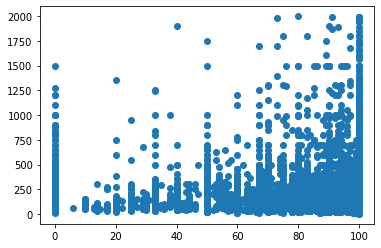

In [ ]:
plt.scatter(alldata_res.host_response_rate_num,alldata_res.y)

In [ ]:
#中央値で穴埋め
alldata_res.host_response_rate_num = alldata_res.host_response_rate_num.fillna(alldata_res.host_response_rate_num.median())

#欠損値がある変数だけが降順に並び替え
alldata_res.isnull().sum()[alldata_res.isnull().sum()>0].sort_values(ascending = False)

y                         18528
review_scores_rating      16722
first_review              15864
last_review               15827
thumbnail_url              8216
neighbourhood              6872
zipcode                     966
bathrooms                   200
host_since                  188
host_identity_verified      188
host_has_profile_pic        188
beds                        131
bedrooms                     91
dtype: int64

In [ ]:
alldata_res.loc[alldata_res.host_response_rate_num ==0,"response_rate_group"]="0"
alldata_res.loc[(alldata_res.host_response_rate_num >0) & (alldata_res.host_response_rate_num <50),"response_rate_group"]="050"
alldata_res.loc[(alldata_res.host_response_rate_num >=50) & (alldata_res.host_response_rate_num <75),"response_rate_group"]="5075"
alldata_res.loc[(alldata_res.host_response_rate_num >=75) & (alldata_res.host_response_rate_num <97) ,"response_rate_group"]="7597"
alldata_res.loc[alldata_res.host_response_rate_num >=97 ,"response_rate_group"]="97100"

alldata_res.drop(["host_response_rate_num"],axis=1)

alldata_res.head()

,y,TrainFlag,id,accommodates,amenities,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,description,first_review,host_has_profile_pic,host_identity_verified,host_since,instant_bookable,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,property_type,review_scores_rating,room_type,thumbnail_url,zipcode,host_response_rate_num,response_rate_group
0,138.0,True,0,6,"{TV,""Wireless Internet"",Kitchen,""Free parking ...",2.0,Real Bed,1.0,4.0,flexible,LA,t,My place is meant for family and a few friends...,2016-07-27,t,f,2016-07-13,f,2016-07-27,33.788931,-118.154761,The Penthouse,NaN,1,Apartment,60.0,Private room,NaN,90804,100.0,97100
1,42.0,True,1,2,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",1.0,Real Bed,1.0,1.0,strict,DC,t,This is a new listing for a lovely guest bedro...,2016-09-12,t,t,2015-12-30,f,2017-03-31,38.934810,-76.978190,Guest Bedroom in Brookland,Brookland,9,House,100.0,Private room,https://a0.muscache.com/im/pictures/e4d8b51f-6...,20018,100.0,97100
2,65.0,True,2,2,"{TV,Internet,""Wireless Internet"",Kitchen,""Indo...",2.0,Real Bed,1.0,1.0,strict,NYC,t,We're looking forward to your stay at our apt....,2016-06-15,t,f,2016-05-21,t,2017-08-13,40.695118,-73.926240,Clean Modern Room in Lux Apt 1 Block From J Train,Bushwick,27,Apartment,83.0,Private room,https://a0.muscache.com/im/pictures/5ffecc9b-d...,NaN,100.0,97100
3,166.0,True,3,2,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",1.0,Real Bed,1.0,1.0,strict,SF,t,BEST CITY VIEWS - - ROOF DECK W/ BBQ & WiFi - ...,2014-03-15,t,t,2012-06-19,t,2017-09-03,37.796728,-122.411906,BEST views + reviews! 5/5 stars*****,Nob Hill,38,Apartment,95.0,Private room,NaN,94133,100.0,97100
4,165.0,True,4,2,"{TV,Internet,""Wireless Internet"",""Air conditio...",1.0,Real Bed,1.0,1.0,strict,NYC,t,Charming Apartment on the upper west side of M...,2015-08-05,t,t,2015-03-25,f,2017-09-10,40.785050,-73.974691,Charming 1-bedroom - UWS Manhattan,Upper West Side,5,Apartment,100.0,Entire home/apt,https://a0.muscache.com/im/pictures/92879730/5...,10024,100.0,97100


In [ ]:
alldata_res.shape

(74111, 31)

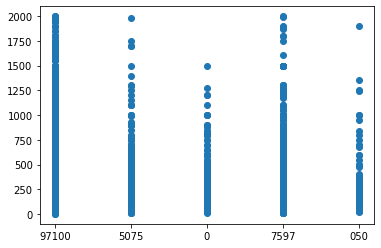

In [ ]:
plt.scatter(alldata_res.response_rate_group,alldata_res.y)

###review_scores_rating

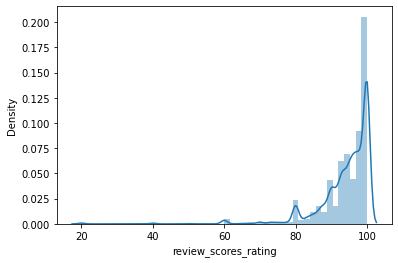

In [ ]:
sns.distplot(alldata_res["review_scores_rating"])


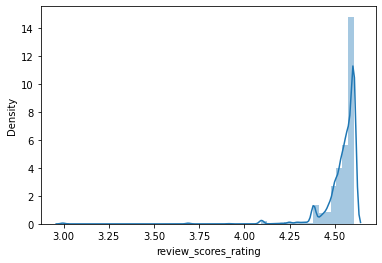

In [ ]:
sns.distplot(np.log(alldata_res["review_scores_rating"]))

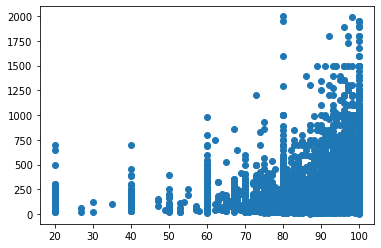

In [ ]:
plt.scatter(alldata_res.review_scores_rating,alldata_res.y)

In [ ]:
#中央値で穴埋め
alldata_res.review_scores_rating = alldata_res.review_scores_rating.fillna(alldata_res.review_scores_rating.median())

#欠損値がある変数だけが降順に並び替え
alldata_res.isnull().sum()[alldata_res.isnull().sum()>0].sort_values(ascending = False)

y                         18528
first_review              15864
last_review               15827
thumbnail_url              8216
neighbourhood              6872
zipcode                     966
bathrooms                   200
host_since                  188
host_identity_verified      188
host_has_profile_pic        188
beds                        131
bedrooms                     91
dtype: int64

In [ ]:
# #特徴量の追加
#あまり効果無さそう
#alldata_res['hasreview'] = alldata_res['review_scores_rating'].apply(lambda x: 1 if x > 0 else 0)

#plt.scatter(alldata_res.hasreview,alldata_res.y)
#print(alldata_res[alldata_res.hasreview==1].y.mean())#reviewあり
#print(alldata_res[alldata_res.hasreview==0].y.mean())#reviewなし

#alldata_res=alldata_res.drop(["hasreview"],axis=1)
#alldata_res.head()

In [ ]:
#sns.swarmplot(alldata_res.city,alldata_res.y,data=alldata_res)

In [ ]:
#pd.plotting.scatter_matrix(alldata_res)

In [ ]:
#alldata_res.thumbnail_url
# #特徴量の追加
#あまり効果無さそう
alldata_res['hasthumbnail'] = alldata_res['thumbnail_url'].apply(lambda x: 1 if pd.isna(x) != True else 0)
alldata_res.tail()
#plt.scatter(alldata_res.hasreview,alldata_res.y)

,y,TrainFlag,id,accommodates,amenities,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,description,first_review,host_has_profile_pic,host_identity_verified,host_since,instant_bookable,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,property_type,review_scores_rating,room_type,thumbnail_url,zipcode,host_response_rate_num,response_rate_group,hasthumbnail
18523,NaN,False,18523,4,"{TV,Internet,""Wireless Internet"",""Air conditio...",1.0,Real Bed,2.0,2.0,strict,NYC,t,"The Greenhouse, located on Green Street, is a ...",NaN,t,t,2009-11-16,f,NaN,40.734555,-73.954892,Spacious 2BR Greenpoint Getaway,Greenpoint,0,Apartment,96.0,Entire home/apt,https://a0.muscache.com/im/pictures/57338613/6...,11222,100.0,97100,1
18524,NaN,False,18524,2,"{TV,""Wireless Internet"",""Air conditioning"",Kit...",1.0,Real Bed,2.0,1.0,flexible,Chicago,f,"Two bedroom, one bathroom with large dining/li...",2017-01-16,t,f,2017-01-08,f,2017-04-11,41.945939,-87.672018,Walk up Apartment in Lakeview/Wrigleyville,Lakeview,9,Apartment,90.0,Entire home/apt,NaN,60657,100.0,97100,0
18525,NaN,False,18525,5,"{TV,""Wireless Internet"",""Air conditioning"",Kit...",1.5,Real Bed,2.0,2.0,flexible,Chicago,t,Happy Holidays! If you're looking for a big op...,NaN,t,f,2014-09-02,f,NaN,41.933123,-87.708087,Beautiful Logan Square Home,Avondale,0,House,96.0,Entire home/apt,https://a0.muscache.com/im/pictures/361642af-e...,60618,100.0,97100,1
18526,NaN,False,18526,2,"{Internet,""Wireless Internet"",""Air conditionin...",1.0,Real Bed,1.0,2.0,strict,NYC,t,This is a cozy one-bedroom apartment a few blo...,2016-04-15,t,f,2014-03-17,f,2017-05-08,40.788702,-73.947358,Charming 1 BR apartment east of Central Park,East Harlem,4,Apartment,95.0,Entire home/apt,https://a0.muscache.com/im/pictures/49c8e83f-d...,10029.0,100.0,97100,1
18527,NaN,False,18527,1,"{TV,Internet,""Wireless Internet"",Kitchen,""Elev...",1.0,Real Bed,1.0,1.0,strict,LA,f,Charming clean living room for rent. Amenities...,2015-08-26,t,f,2015-08-19,t,2017-01-24,34.110704,-118.289092,Clean Spacious living room for rent,NaN,21,Apartment,97.0,Shared room,https://a0.muscache.com/im/pictures/101177389/...,90027,100.0,97100,1


サムネイル持っている方が高い，という仮説違ってそう

153.02180508920264
217.6214808787632


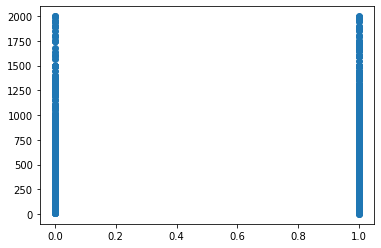

In [ ]:
plt.scatter(alldata_res.hasthumbnail,alldata_res.y)
print(alldata_res[alldata_res.hasthumbnail==1].y.mean())
print(alldata_res[alldata_res.hasthumbnail==0].y.mean())

In [ ]:
alldata_res=alldata_res.drop(["thumbnail_url",'hasthumbnail'],axis=1)
alldata_res.head()

,y,TrainFlag,id,accommodates,amenities,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,description,first_review,host_has_profile_pic,host_identity_verified,host_since,instant_bookable,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,property_type,review_scores_rating,room_type,zipcode,host_response_rate_num,response_rate_group
0,138.0,True,0,6,"{TV,""Wireless Internet"",Kitchen,""Free parking ...",2.0,Real Bed,1.0,4.0,flexible,LA,t,My place is meant for family and a few friends...,2016-07-27,t,f,2016-07-13,f,2016-07-27,33.788931,-118.154761,The Penthouse,NaN,1,Apartment,60.0,Private room,90804,100.0,97100
1,42.0,True,1,2,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",1.0,Real Bed,1.0,1.0,strict,DC,t,This is a new listing for a lovely guest bedro...,2016-09-12,t,t,2015-12-30,f,2017-03-31,38.934810,-76.978190,Guest Bedroom in Brookland,Brookland,9,House,100.0,Private room,20018,100.0,97100
2,65.0,True,2,2,"{TV,Internet,""Wireless Internet"",Kitchen,""Indo...",2.0,Real Bed,1.0,1.0,strict,NYC,t,We're looking forward to your stay at our apt....,2016-06-15,t,f,2016-05-21,t,2017-08-13,40.695118,-73.926240,Clean Modern Room in Lux Apt 1 Block From J Train,Bushwick,27,Apartment,83.0,Private room,NaN,100.0,97100
3,166.0,True,3,2,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",1.0,Real Bed,1.0,1.0,strict,SF,t,BEST CITY VIEWS - - ROOF DECK W/ BBQ & WiFi - ...,2014-03-15,t,t,2012-06-19,t,2017-09-03,37.796728,-122.411906,BEST views + reviews! 5/5 stars*****,Nob Hill,38,Apartment,95.0,Private room,94133,100.0,97100
4,165.0,True,4,2,"{TV,Internet,""Wireless Internet"",""Air conditio...",1.0,Real Bed,1.0,1.0,strict,NYC,t,Charming Apartment on the upper west side of M...,2015-08-05,t,t,2015-03-25,f,2017-09-10,40.785050,-73.974691,Charming 1-bedroom - UWS Manhattan,Upper West Side,5,Apartment,100.0,Entire home/apt,10024,100.0,97100


In [ ]:
#欠損値がある変数だけが降順に並び替え
alldata_res.isnull().sum()[alldata_res.isnull().sum()>0].sort_values(ascending = False)

y                         18528
first_review              15864
last_review               15827
neighbourhood              6872
zipcode                     966
bathrooms                   200
host_since                  188
host_identity_verified      188
host_has_profile_pic        188
beds                        131
bedrooms                     91
dtype: int64

In [ ]:
alldata_res.shape

(74111, 30)

###neighbourhoodの中身

In [ ]:
n_count=alldata_res["neighbourhood"].value_counts()
n_count

Williamsburg          2862
Bedford-Stuyvesant    2166
Bushwick              1601
Upper West Side       1396
Mid-Wilshire          1392
                      ... 
Edison Park              1
Clearing                 1
Vernon                   1
Mill Basin               1
Watertown                1
Name: neighbourhood, Length: 619, dtype: int64

In [ ]:
alldata_res["neighbourhood"].values

array([nan, 'Brookland', 'Bushwick', ..., 'Avondale', 'East Harlem', nan],
      dtype=object)

In [ ]:
#df = pd.DataFrame(columns=alldata_res["neighbourhood"].unique()[1:])
col = alldata_res["neighbourhood"].unique()[1:]
df = pd.DataFrame(index=[], columns=col)
record = pd.Series(['hoge']*619, index=df.columns)
df = df.append(record, ignore_index=True)


for i in alldata_res["neighbourhood"].unique()[1:]:
  ave=alldata_res[alldata_res.neighbourhood==i].y.mean()
  if ave>=300 and n_count[i]>=10:
    df[i]=ave
  else:
    df=df.drop(i,axis=1)

  #df=df.assign(i=ave)
  #print(ave,i)
df

,Telegraph Hill,Presidio Heights,Bel Air/Beverly Crest,Capitol Hill,Navy Yard,Malibu,Downtown/Penn Quarter,Rancho Palos Verdes,Woodley Park,Pacific Heights,Marina,Hermosa Beach,Laurel Canyon,Tribeca,Foxhall,Noho,Russian Hill,Pacific Palisades,Cow Hollow,Judiciary Square,Fisherman's Wharf
0,300.714286,374.181818,491.494624,312.142145,301.296296,561.125984,315.613333,309.826087,307.518519,309.0375,309.93617,318.634921,371.418367,376.8625,368.75,350.414634,324.917647,365.96875,357.924528,426.5,367.210526


In [ ]:
for i in df.columns:
  print(n_count[i],i)

81 Telegraph Hill
31 Presidio Heights
131 Bel Air/Beverly Crest
526 Capitol Hill
35 Navy Yard
185 Malibu
111 Downtown/Penn Quarter
32 Rancho Palos Verdes
36 Woodley Park
208 Pacific Heights
131 Marina
80 Hermosa Beach
135 Laurel Canyon
103 Tribeca
12 Foxhall
49 Noho
110 Russian Hill
128 Pacific Palisades
71 Cow Hollow
55 Judiciary Square
36 Fisherman's Wharf


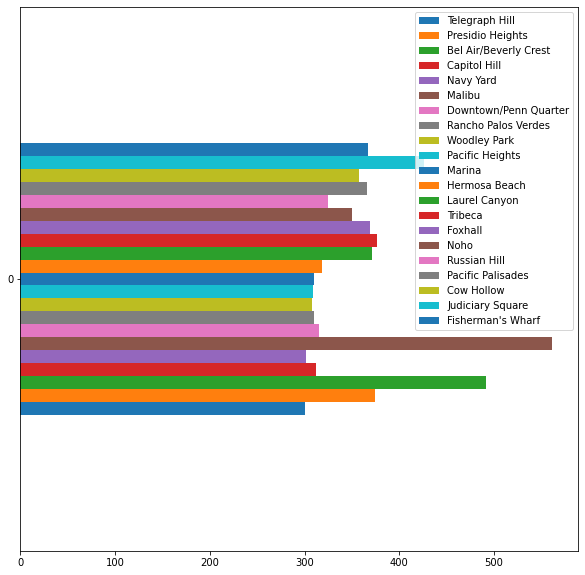

In [ ]:
#plt.figuresize(figsize=(10,10)
df.plot.barh(figsize=(10,10))

In [ ]:
#alldata_res["neighbourhood"]について，df.columnsととothersにする
alldata_res.loc[~alldata_res.neighbourhood.isin(df.columns),"neighbourhood"] ='others'
alldata_res.loc[alldata_res.neighbourhood.isnull()==True,"neighbourhood"] ='others'
alldata_res

,y,TrainFlag,id,accommodates,amenities,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,description,first_review,host_has_profile_pic,host_identity_verified,host_since,instant_bookable,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,property_type,review_scores_rating,room_type,zipcode,host_response_rate_num,response_rate_group
0,138.0,True,0,6,"{TV,""Wireless Internet"",Kitchen,""Free parking ...",2.0,Real Bed,1.0,4.0,flexible,LA,t,My place is meant for family and a few friends...,2016-07-27,t,f,2016-07-13,f,2016-07-27,33.788931,-118.154761,The Penthouse,others,1,Apartment,60.0,Private room,90804,100.0,97100
1,42.0,True,1,2,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",1.0,Real Bed,1.0,1.0,strict,DC,t,This is a new listing for a lovely guest bedro...,2016-09-12,t,t,2015-12-30,f,2017-03-31,38.934810,-76.978190,Guest Bedroom in Brookland,others,9,House,100.0,Private room,20018,100.0,97100
2,65.0,True,2,2,"{TV,Internet,""Wireless Internet"",Kitchen,""Indo...",2.0,Real Bed,1.0,1.0,strict,NYC,t,We're looking forward to your stay at our apt....,2016-06-15,t,f,2016-05-21,t,2017-08-13,40.695118,-73.926240,Clean Modern Room in Lux Apt 1 Block From J Train,others,27,Apartment,83.0,Private room,NaN,100.0,97100
3,166.0,True,3,2,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",1.0,Real Bed,1.0,1.0,strict,SF,t,BEST CITY VIEWS - - ROOF DECK W/ BBQ & WiFi - ...,2014-03-15,t,t,2012-06-19,t,2017-09-03,37.796728,-122.411906,BEST views + reviews! 5/5 stars*****,others,38,Apartment,95.0,Private room,94133,100.0,97100
4,165.0,True,4,2,"{TV,Internet,""Wireless Internet"",""Air conditio...",1.0,Real Bed,1.0,1.0,strict,NYC,t,Charming Apartment on the upper west side of M...,2015-08-05,t,t,2015-03-25,f,2017-09-10,40.785050,-73.974691,Charming 1-bedroom - UWS Manhattan,others,5,Apartment,100.0,Entire home/apt,10024,100.0,97100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18523,NaN,False,18523,4,"{TV,Internet,""Wireless Internet"",""Air conditio...",1.0,Real Bed,2.0,2.0,strict,NYC,t,"The Greenhouse, located on Green Street, is a ...",NaN,t,t,2009-11-16,f,NaN,40.734555,-73.954892,Spacious 2BR Greenpoint Getaway,others,0,Apartment,96.0,Entire home/apt,11222,100.0,97100
18524,NaN,False,18524,2,"{TV,""Wireless Internet"",""Air conditioning"",Kit...",1.0,Real Bed,2.0,1.0,flexible,Chicago,f,"Two bedroom, one bathroom with large dining/li...",2017-01-16,t,f,2017-01-08,f,2017-04-11,41.945939,-87.672018,Walk up Apartment in Lakeview/Wrigleyville,others,9,Apartment,90.0,Entire home/apt,60657,100.0,97100
18525,NaN,False,18525,5,"{TV,""Wireless Internet"",""Air conditioning"",Kit...",1.5,Real Bed,2.0,2.0,flexible,Chicago,t,Happy Holidays! If you're looking for a big op...,NaN,t,f,2014-09-02,f,NaN,41.933123,-87.708087,Beautiful Logan Square Home,others,0,House,96.0,Entire home/apt,60618,100.0,97100
18526,NaN,False,18526,2,"{Internet,""Wireless Internet"",""Air conditionin...",1.0,Real Bed,1.0,2.0,strict,NYC,t,This is a cozy one-bedroom apartment a few blo...,2016-04-15,t,f,2014-03-17,f,2017-05-08,40.788702,-73.947358,Charming 1 BR apartment east of Central Park,others,4,Apartment,95.0,Entire home/apt,10029.0,100.0,97100


In [ ]:
#欠損値がある変数だけが降順に並び替え
alldata_res.isnull().sum()[alldata_res.isnull().sum()>0].sort_values(ascending = False)

y                         18528
first_review              15864
last_review               15827
zipcode                     966
bathrooms                   200
host_since                  188
host_identity_verified      188
host_has_profile_pic        188
beds                        131
bedrooms                     91
dtype: int64

###bedrooms

(array([6.7150e+03, 4.9784e+04, 1.1351e+04, 4.3090e+03, 1.3300e+03,
        3.5500e+02, 1.0600e+02, 3.8000e+01, 1.4000e+01, 1.8000e+01]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <a list of 10 Patch objects>)

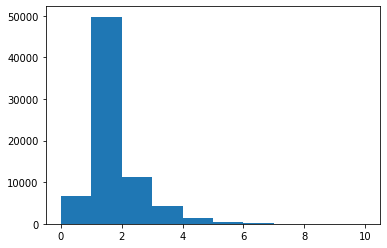

In [ ]:
plt.hist(alldata_res.bedrooms)

bedroom数は中央値で穴埋め

In [ ]:
alldata_res.bedrooms=alldata_res.bedrooms.fillna(alldata_res.bedrooms.median())
alldata_res

,y,TrainFlag,id,accommodates,amenities,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,description,first_review,host_has_profile_pic,host_identity_verified,host_since,instant_bookable,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,property_type,review_scores_rating,room_type,zipcode,host_response_rate_num,response_rate_group
0,138.0,True,0,6,"{TV,""Wireless Internet"",Kitchen,""Free parking ...",2.0,Real Bed,1.0,4.0,flexible,LA,t,My place is meant for family and a few friends...,2016-07-27,t,f,2016-07-13,f,2016-07-27,33.788931,-118.154761,The Penthouse,NaN,1,Apartment,60.0,Private room,90804,100.0,97100
1,42.0,True,1,2,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",1.0,Real Bed,1.0,1.0,strict,DC,t,This is a new listing for a lovely guest bedro...,2016-09-12,t,t,2015-12-30,f,2017-03-31,38.934810,-76.978190,Guest Bedroom in Brookland,Brookland,9,House,100.0,Private room,20018,100.0,97100
2,65.0,True,2,2,"{TV,Internet,""Wireless Internet"",Kitchen,""Indo...",2.0,Real Bed,1.0,1.0,strict,NYC,t,We're looking forward to your stay at our apt....,2016-06-15,t,f,2016-05-21,t,2017-08-13,40.695118,-73.926240,Clean Modern Room in Lux Apt 1 Block From J Train,Bushwick,27,Apartment,83.0,Private room,NaN,100.0,97100
3,166.0,True,3,2,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",1.0,Real Bed,1.0,1.0,strict,SF,t,BEST CITY VIEWS - - ROOF DECK W/ BBQ & WiFi - ...,2014-03-15,t,t,2012-06-19,t,2017-09-03,37.796728,-122.411906,BEST views + reviews! 5/5 stars*****,Nob Hill,38,Apartment,95.0,Private room,94133,100.0,97100
4,165.0,True,4,2,"{TV,Internet,""Wireless Internet"",""Air conditio...",1.0,Real Bed,1.0,1.0,strict,NYC,t,Charming Apartment on the upper west side of M...,2015-08-05,t,t,2015-03-25,f,2017-09-10,40.785050,-73.974691,Charming 1-bedroom - UWS Manhattan,Upper West Side,5,Apartment,100.0,Entire home/apt,10024,100.0,97100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18523,NaN,False,18523,4,"{TV,Internet,""Wireless Internet"",""Air conditio...",1.0,Real Bed,2.0,2.0,strict,NYC,t,"The Greenhouse, located on Green Street, is a ...",NaN,t,t,2009-11-16,f,NaN,40.734555,-73.954892,Spacious 2BR Greenpoint Getaway,Greenpoint,0,Apartment,96.0,Entire home/apt,11222,100.0,97100
18524,NaN,False,18524,2,"{TV,""Wireless Internet"",""Air conditioning"",Kit...",1.0,Real Bed,2.0,1.0,flexible,Chicago,f,"Two bedroom, one bathroom with large dining/li...",2017-01-16,t,f,2017-01-08,f,2017-04-11,41.945939,-87.672018,Walk up Apartment in Lakeview/Wrigleyville,Lakeview,9,Apartment,90.0,Entire home/apt,60657,100.0,97100
18525,NaN,False,18525,5,"{TV,""Wireless Internet"",""Air conditioning"",Kit...",1.5,Real Bed,2.0,2.0,flexible,Chicago,t,Happy Holidays! If you're looking for a big op...,NaN,t,f,2014-09-02,f,NaN,41.933123,-87.708087,Beautiful Logan Square Home,Avondale,0,House,96.0,Entire home/apt,60618,100.0,97100
18526,NaN,False,18526,2,"{Internet,""Wireless Internet"",""Air conditionin...",1.0,Real Bed,1.0,2.0,strict,NYC,t,This is a cozy one-bedroom apartment a few blo...,2016-04-15,t,f,2014-03-17,f,2017-05-08,40.788702,-73.947358,Charming 1 BR apartment east of Central Park,East Harlem,4,Apartment,95.0,Entire home/apt,10029.0,100.0,97100


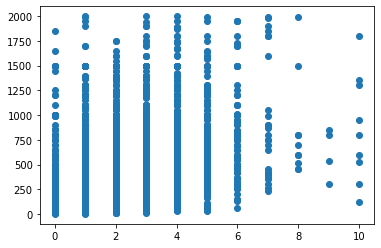

In [ ]:
plt.scatter(alldata_res.bedrooms,alldata_res.y)

Text(0, 0.5, 'beds')

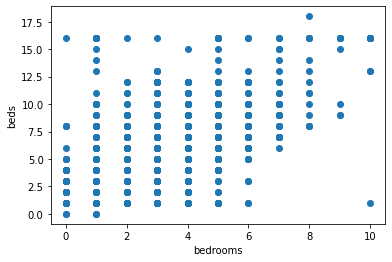

In [ ]:
plt.scatter(alldata_res.bedrooms,alldata_res.beds)
plt.xlabel("bedrooms")
plt.ylabel("beds")

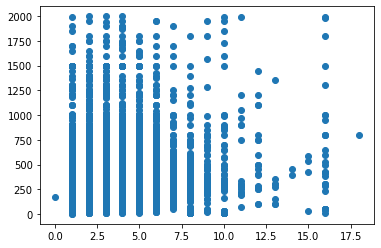

In [ ]:
plt.scatter(alldata_res.beds,alldata_res.y)

1.0

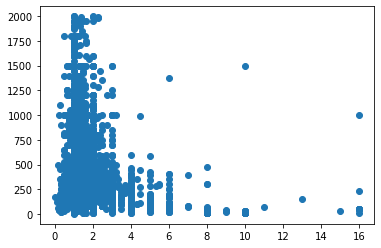

In [ ]:
plt.scatter(alldata_res.beds/alldata_res.bedrooms,alldata_res.y)
#alldata_res.beds/alldata_res
alldata_res["alldata_res.beds/alldata_res.bedrooms"]=alldata_res.beds/alldata_res.bedrooms
alldata_res["alldata_res.beds/alldata_res.bedrooms"].median()


In [ ]:
alldata_res=alldata_res.drop('alldata_res.beds/alldata_res.bedrooms', axis=1)
alldata_res.head(1)

,y,TrainFlag,id,accommodates,amenities,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,description,first_review,host_has_profile_pic,host_identity_verified,host_since,instant_bookable,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,property_type,review_scores_rating,room_type,zipcode,host_response_rate_num,response_rate_group
0,138.0,True,0,6,"{TV,""Wireless Internet"",Kitchen,""Free parking ...",2.0,Real Bed,1.0,4.0,flexible,LA,t,My place is meant for family and a few friends...,2016-07-27,t,f,2016-07-13,f,2016-07-27,33.788931,-118.154761,The Penthouse,NaN,1,Apartment,60.0,Private room,90804,100.0,97100


In [ ]:
alldata_res.shape

(74111, 30)

beds=bedroomsで穴埋め

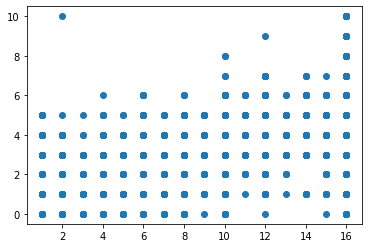

In [ ]:
plt.scatter(alldata_res.accommodates,alldata_res.bedrooms)

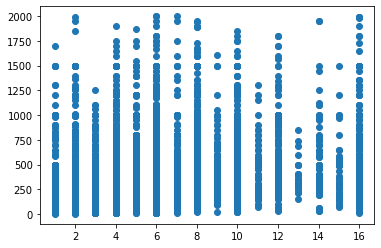

In [ ]:
plt.scatter(alldata_res.accommodates,alldata_res.y)

bedroom数がbed数を超えているものは修正

In [ ]:
alldata_res[alldata_res.bedrooms==10]
#31081のデータ誤ってそう

,y,TrainFlag,id,accommodates,amenities,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,description,first_review,host_has_profile_pic,host_identity_verified,host_since,instant_bookable,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,property_type,review_scores_rating,room_type,zipcode,host_response_rate_num,response_rate_group
5600,1300.0,True,5600,16,"{Internet,""Wireless Internet"",Kitchen,""Family/...",7.0,Real Bed,10.0,16.0,flexible,LA,f,Hello! We're LA Chosun House located in the he...,NaN,t,f,2016-04-21,f,NaN,34.048690,-118.319579,12 Bedroom House in heart of LA!,Mid-Wilshire,0,House,96.0,Entire home/apt,90019,100.0,97100
18845,522.0,True,18845,16,"{TV,""Wireless Internet"",""Air conditioning"",Kit...",4.0,Real Bed,10.0,16.0,flexible,NYC,f,Open concepts with ceiling led lighting in eve...,NaN,t,f,2016-08-29,t,NaN,40.674952,-73.819140,Vacation Homes By JFK Aiprort,South Ozone Park,0,House,96.0,Entire home/apt,11420,0.0,0
26577,595.0,True,26577,16,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",7.0,Real Bed,10.0,16.0,strict,LA,f,"10 bedrooms,7 baths; sleeps 29 in 26 (URL HIDD...",2016-05-15,t,t,2014-07-08,t,2017-04-30,33.975376,-118.295995,10 Bedrms;26 beds; Sleep 29; 7 baths; 2 Kitchens,South LA,16,House,100.0,Entire home/apt,90044,100.0,97100
27149,950.0,True,27149,16,"{TV,Internet,""Wireless Internet"",""Air conditio...",8.0,Real Bed,10.0,16.0,strict,LA,t,Combination of 4 apartments. Please fill free ...,NaN,t,t,2015-11-24,f,NaN,34.166328,-118.449249,Combo Apt UP to 40 People,NaN,0,Apartment,96.0,Entire home/apt,91411,88.0,7597
31081,125.0,True,31081,2,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",1.0,Real Bed,10.0,1.0,moderate,Boston,t,"A Large, Loft Style, open space unit. With tal...",2017-09-04,t,f,2017-03-25,t,2017-10-02,42.325429,-71.096466,Loft Style 1 mile from Downtown Boston Brownst...,Roxbury,4,Townhouse,90.0,Entire home/apt,02119,100.0,97100
31899,1800.0,True,31899,16,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",8.0,Real Bed,10.0,16.0,flexible,NYC,t,This stylishly renovated building is near Kiss...,NaN,t,f,2017-06-28,f,NaN,40.756319,-73.808298,New Metropolitan Guest House - 新大都會藝術客居,Flushing,0,House,96.0,Entire home/apt,11355,100.0,97100
36021,299.0,True,36021,16,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",5.0,Real Bed,10.0,16.0,strict,Chicago,t,"SLEEP 30 in a FOUR-FLOOR HOUSE, HALF A BLOCK f...",2015-10-22,t,t,2014-01-08,f,2017-03-19,41.947212,-87.655574,"Sleep 30, HALF-BLOCK from Wrigley!",Wrigleyville,13,House,95.0,Entire home/apt,60613,100.0,97100
40467,800.0,True,40467,16,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",8.0,Real Bed,10.0,16.0,strict,LA,t,This is for all four 3br/2 ba duplex units in ...,NaN,t,t,2012-08-06,f,NaN,33.973192,-118.370161,New 4-plex 12 br/8 ba @ La Cienega Villas by LAX,NaN,0,House,96.0,Entire home/apt,90045,100.0,97100
48369,1350.0,True,48369,16,"{""Cable TV"",""Wireless Internet"",""Air condition...",4.0,Real Bed,10.0,13.0,strict,NYC,t,Do you have a group coming to NYC and would al...,2015-06-21,t,t,2015-01-29,t,2016-06-04,40.692834,-73.956043,NYC Private Group Stay (10 Bedrooms 4 Bathrooms),Bedford-Stuyvesant,4,House,95.0,Entire home/apt,11205,100.0,97100
17726,NaN,False,17726,16,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",6.0,Real Bed,10.0,13.0,strict,NYC,t,Newly renovated and furnished with all new bed...,2017-05-02,t,t,2014-06-10,t,2017-08-29,40.713844,-73.947621,INCREDIBLE TOWNHOUSE 3 STORIES 10 BEDROOMS 6 BATH,Williamsburg,7,House,89.0,Entire home/apt,11211.0,93.0,7597


In [ ]:
#alldata_res.loc[alldata_res.bedrooms > alldata_res.beds , "bedrooms"] = alldata_res.loc[alldata_res.bedrooms > alldata_res.beds , "beds"]
#alldata_res

In [ ]:
#alldata_res[alldata_res.bedrooms==10]

Text(0, 0.5, 'beds')

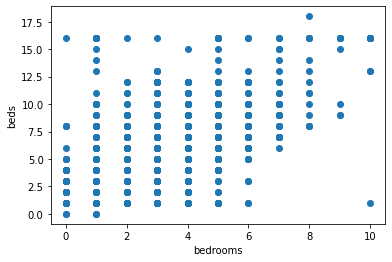

In [ ]:
plt.scatter(alldata_res.bedrooms,alldata_res.beds)
plt.xlabel("bedrooms")
plt.ylabel("beds")

(array([6.7150e+03, 4.9875e+04, 1.1351e+04, 4.3090e+03, 1.3300e+03,
        3.5500e+02, 1.0600e+02, 3.8000e+01, 1.4000e+01, 1.8000e+01]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <a list of 10 Patch objects>)

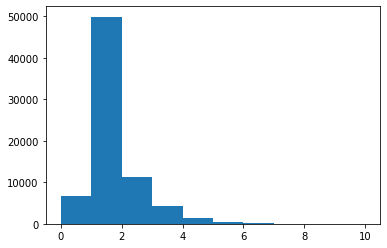

In [ ]:
plt.hist(alldata_res.bedrooms)

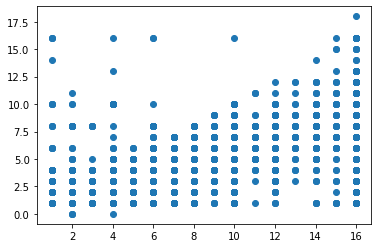

In [ ]:
plt.scatter(alldata_res.accommodates,alldata_res.beds)

In [ ]:
alldata_res[alldata_res.accommodates<alldata_res.beds]

,y,TrainFlag,id,accommodates,amenities,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,description,first_review,host_has_profile_pic,host_identity_verified,host_since,instant_bookable,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,property_type,review_scores_rating,room_type,zipcode,host_response_rate_num,response_rate_group
40,73.0,True,40,1,"{""Wireless Internet"",""Air conditioning"",Elevat...",1.0,Real Bed,1.0,2.0,flexible,NYC,f,Nice and Clean Big Room It start available Aug...,NaN,t,f,2014-07-17,t,NaN,40.744620,-73.916539,10 minutes to Manhattan,Sunnyside,0,Apartment,96.0,Private room,11104,75.0,7597
147,53.0,True,147,3,"{TV,""Wireless Internet"",""Air conditioning"",Kit...",2.0,Real Bed,1.0,4.0,strict,LA,t,> Located IN THE HEART OF L.A. by Upscale Melr...,2016-07-04,t,t,2015-02-01,f,2016-10-29,34.084138,-118.343823,PRIVATE ROOM IN LUXURIOUS HOLLYWOOD VILLA,West Hollywood,8,House,83.0,Private room,90038,95.0,7597
200,200.0,True,200,4,"{TV,Internet,""Wireless Internet"",""Air conditio...",1.0,Real Bed,2.0,5.0,strict,NYC,t,2 bedrooms Upper West Side 1 block of Central ...,2015-04-20,t,t,2013-02-14,f,2016-09-23,40.793547,-73.967140,"2 bedrooms - Upper west side, NYC",Upper West Side,5,Apartment,100.0,Entire home/apt,10025,100.0,97100
760,120.0,True,760,1,"{TV,""Wireless Internet"",Kitchen,""Pets allowed""...",1.0,Real Bed,1.0,2.0,strict,Boston,t,Central 1BD apartment in Theater District No p...,2017-07-10,t,t,2015-12-11,t,2017-08-08,42.350050,-71.065176,Central 1 BD in Theater District,Theater District,4,Apartment,100.0,Entire home/apt,02116,100.0,97100
1067,65.0,True,1067,2,"{TV,Internet,""Wireless Internet"",""Air conditio...",2.0,Real Bed,4.0,4.0,strict,LA,t,Great space located in Central LA. Very close...,2016-10-04,t,f,2016-07-04,t,2017-01-30,33.936834,-118.314498,Peaceful Private Room / Breakfast / Parking,Westmont,14,House,93.0,Private room,90047,100.0,97100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17851,NaN,False,17851,2,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",2.0,Real Bed,1.0,4.0,strict,NYC,t,3 bedroom fairly new Condo (5 years old) in B...,NaN,t,t,2009-11-11,f,NaN,40.643359,-73.983787,Main Bedroom with Private Bathroom,Kensington,0,Condominium,96.0,Private room,11218,80.0,7597
17936,NaN,False,17936,1,"{Doorman,Elevator,""Smoke detector""}",1.0,Real Bed,1.0,2.0,flexible,NYC,f,very reasonable clean easy access to all taxis...,NaN,t,f,2015-07-01,f,NaN,40.752548,-73.980033,midtown apartment,Midtown East,0,Apartment,96.0,Entire home/apt,10017,100.0,97100
18118,NaN,False,18118,1,"{Internet,""Wireless Internet"",""Air conditionin...",1.0,Real Bed,1.0,2.0,flexible,LA,f,With clean sheets and pillows this couch will ...,NaN,t,f,2016-08-25,f,NaN,33.837194,-118.186755,Comfortable Red Couch Available,NaN,0,Apartment,96.0,Shared room,90807,100.0,97100
18300,NaN,False,18300,1,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",3.0,Real Bed,1.0,3.0,moderate,NYC,f,"Great for Pilots, FA's being home based at LGA...",2017-09-15,t,f,2017-03-11,f,2017-09-28,40.766494,-73.882904,15 min walk to LGA. Pilots & FA only.,East Elmhurst,6,House,100.0,Shared room,NaN,100.0,97100


In [ ]:
alldata_res.shape

(74111, 30)

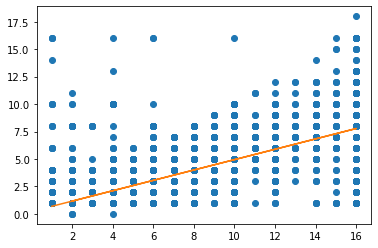

モデル関数の回帰変数 w1: 0.472
モデル関数の切片 w2: 0.220
y= 0.472x + 0.220
決定係数 R^2：  0.6573994623363446


In [ ]:
model_lr = LinearRegression()
alldata_drop=alldata_res
alldata_drop=alldata_drop.dropna(subset=['beds'])
alldata_drop2=alldata_drop
alldata_drop2=alldata_drop2.drop(alldata_drop2.accommodates=="Shared room")
x=alldata_drop2.accommodates.values.reshape(-1, 1)
y=alldata_drop2.beds.values.reshape(-1, 1)
model_lr.fit(x, y)
plt.plot(x, y, 'o')
plt.plot(x, model_lr.predict(x), linestyle="solid")
plt.show()

print('モデル関数の回帰変数 w1: %.3f' %model_lr.coef_)
print('モデル関数の切片 w2: %.3f' %model_lr.intercept_)
print('y= %.3fx + %.3f' % (model_lr.coef_ , model_lr.intercept_))
print('決定係数 R^2： ', model_lr.score(x, y))

In [ ]:
alldata_res.shape

(74111, 30)

In [ ]:
alldata_drop[(alldata_drop.beds>=5) & (alldata_drop.accommodates==1)]

,y,TrainFlag,id,accommodates,amenities,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,description,first_review,host_has_profile_pic,host_identity_verified,host_since,instant_bookable,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,property_type,review_scores_rating,room_type,zipcode,host_response_rate_num,response_rate_group
2279,105.0,True,2279,1,"{TV,""Wireless Internet"",""Air conditioning"",Kit...",1.0,Real Bed,2.0,6.0,flexible,NYC,f,"The house in neat and cozy, with furniture, ap...",NaN,t,f,2017-07-29,t,NaN,40.575091,-74.096062,2 BD cozy house,Midland Beach,0,House,96.0,Entire home/apt,10306,0.0,0
12464,42.0,True,12464,1,"{Internet,""Wireless Internet"",Kitchen,""Free pa...",1.0,Real Bed,1.0,6.0,moderate,LA,f,Top bunkbed in a shared room. 3 Bunkbeds in th...,2015-07-09,t,f,2013-05-20,f,2017-04-14,33.917886,-118.406854,Comfortable top bunkbed shared room,El Segundo,134,Apartment,94.0,Shared room,90245,92.0,7597
17557,15.0,True,17557,1,"{TV,""Wireless Internet"",""Air conditioning"",Kit...",4.0,Real Bed,1.0,10.0,strict,LA,f,A nice and comfy bunk bed in a shared room for...,2016-06-25,t,t,2016-03-21,t,2017-04-27,34.054986,-118.288047,AFFORDABLE ! BUNK BED DOWNTOWN !,Westlake,50,Dorm,88.0,Shared room,90006,99.0,97100
17706,15.0,True,17706,1,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",4.0,Real Bed,1.0,10.0,strict,LA,f,A nice and comfy bunk bed in a shared room for...,2016-08-26,t,t,2016-03-21,t,2017-04-15,34.042068,-118.282794,STEPS FROM USC !! 5 MIN TO DOWNTOWN !,Mid-City,31,Dorm,85.0,Shared room,90006,99.0,97100
20674,33.0,True,20674,1,"{Internet,""Wireless Internet"",Washer,Dryer,""Sm...",1.0,Real Bed,1.0,6.0,flexible,SF,f,We are Hotel/Hostel located very close to down...,2016-11-13,t,f,2016-11-04,f,2017-08-14,37.787657,-122.420470,Single Bed in Music Themed Hotel/Hostel,Downtown,24,Hostel,88.0,Shared room,94109,50.0,5075
21482,54.0,True,21482,1,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",8.0,Real Bed,1.0,8.0,flexible,DC,t,"We are Washington, D.C.'s newest and most mode...",2016-02-14,t,f,2016-01-31,t,2017-05-07,38.919733,-77.041182,1 Bed in Upscale Hostel Shared Room,Adams Morgan,88,Dorm,97.0,Shared room,20009,100.0,97100
24122,15.0,True,24122,1,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",4.0,Real Bed,1.0,10.0,strict,LA,f,A nice and comfy bunk bed in a shared room for...,2016-06-25,t,t,2016-03-21,t,2017-03-19,34.042866,-118.286975,"STEPS FROM USC , DOWNTOWN !!",Mid-City,23,Apartment,83.0,Shared room,90006,99.0,97100
29406,28.0,True,29406,1,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",2.0,Real Bed,1.0,8.0,flexible,DC,f,"Close to Subway, Convention Center.",2016-03-28,t,f,2015-07-08,f,2017-05-06,38.912064,-77.022515,8 Bed Mix dorm,Shaw,48,Dorm,80.0,Shared room,20001,95.0,7597
31419,50.0,True,31419,1,"{TV,""Wireless Internet"",""Air conditioning"",Kit...",2.0,Real Bed,1.0,16.0,strict,LA,f,PodShare is a co-living space in the heart of ...,2016-04-07,t,t,2009-07-22,t,2017-04-16,34.049340,-118.234292,Arts District Co-Living Space,Arts District,78,Dorm,94.0,Shared room,90012,95.0,7597
32702,45.0,True,32702,1,{},1.0,Real Bed,1.0,6.0,flexible,NYC,f,Our homey CrashPad provides clean a comfortabl...,2017-07-27,t,f,2016-03-19,f,2017-09-11,40.703754,-73.830404,CrashPadsUSA for Airline Crew. Nightly HOTBEDS,Richmond Hill,3,House,100.0,Shared room,11415,100.0,97100


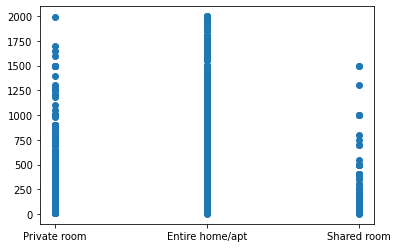

In [ ]:
plt.scatter(alldata_drop.room_type,alldata_drop.y)

In [ ]:
alldata_drop.groupby("room_type").beds.mean()

room_type
Entire home/apt    2.107897
Private room       1.172237
Shared room        1.741740
Name: beds, dtype: float64

In [ ]:
alldata_res.shape

(74111, 30)

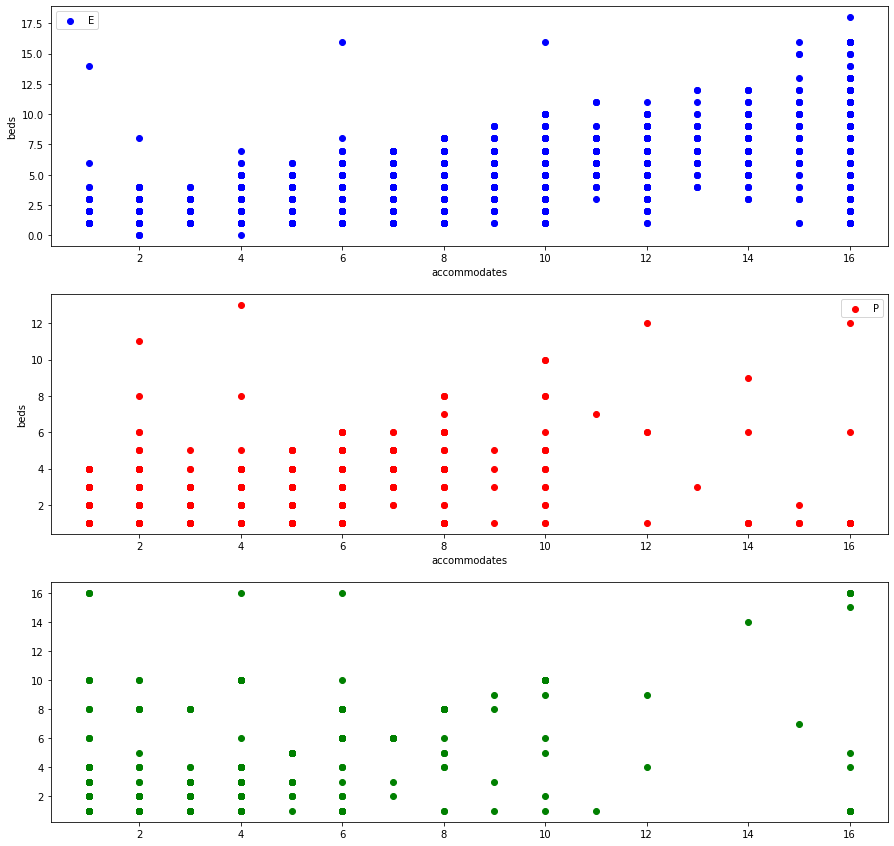

In [ ]:
#2行1列のaxesを生成
fig,ax=plt.subplots(3,1,figsize=(15,15))

df_E  =alldata_drop[alldata_drop["room_type"]=="Entire home/apt"][["accommodates","beds"]]
df_P=alldata_drop[alldata_drop["room_type"]=="Private room"][["accommodates","beds"]]
df_S  =alldata_drop[alldata_drop["room_type"]=="Shared room"][["accommodates","beds"]]


ax[0].scatter(df_E["accommodates"],df_E["beds"],label="E",color="blue")
ax[1].scatter(df_P["accommodates"],df_P["beds"],label="P",color="red")
ax[2].scatter(df_S["accommodates"],df_S["beds"],label="S",color="green")

for i in range(2):
    ax[i].set_xlabel("accommodates")
    ax[i].set_ylabel("beds")
    ax[i].legend()

In [ ]:
#if alldata_res["room_type"]=='Entire home/apt' or alldata_res["room_type"]=='Private room':

#for column in alldata.columns:
    # dtypeがobjectの場合、文字列の変数
#    if alldata[column].dtype=='O':
#        alldata[column] = alldata[column].fillna(alldata[column].mode().iloc[0])
    # dtypeがint , floatの場合、数字の変数
#    else:
#        alldata[column] = alldata[column].fillna(alldata[column].median())

In [ ]:
alldata_res.beds=alldata_res.beds.fillna(alldata_res.bedrooms)
#欠損値がある変数だけが降順に並び替え
alldata_res.isnull().sum()[alldata_res.isnull().sum()>0].sort_values(ascending = False)

y                         18528
first_review              15864
last_review               15827
neighbourhood              6872
zipcode                     966
bathrooms                   200
host_since                  188
host_identity_verified      188
host_has_profile_pic        188
dtype: int64

In [ ]:
alldata_res.shape

(74111, 30)

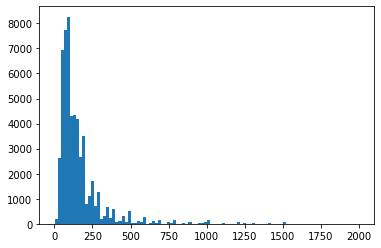

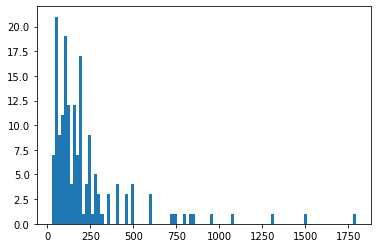

In [ ]:
#alldata_res.groupby("host_has_profile_pic").y.mean()
plt.hist(alldata_res[alldata_res["host_has_profile_pic"]=="t"].y,bins=100)
plt.show()
plt.hist(alldata_res[alldata_res["host_has_profile_pic"]=="f"].y,bins=100)
plt.show()

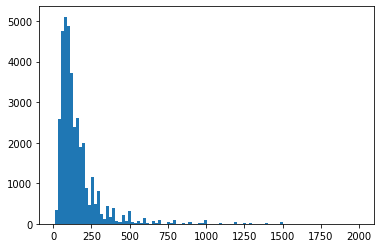

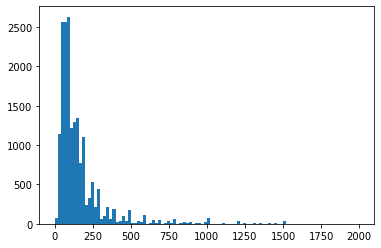

In [ ]:
alldata_res.groupby("host_identity_verified").y.mean()
plt.hist(alldata_res[alldata_res["host_identity_verified"]=="t"].y,bins=100)
plt.show()
plt.hist(alldata_res[alldata_res["host_identity_verified"]=="f"].y,bins=100)
plt.show()

host_identity_verifiedとhost_has_profile_picは値段に関係なさそうなので削除

In [ ]:
alldata_res=alldata_res.drop(['host_identity_verified','host_has_profile_pic'], axis=1)
alldata_res.head(1)

,y,TrainFlag,id,accommodates,amenities,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,description,first_review,host_since,instant_bookable,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,property_type,review_scores_rating,room_type,zipcode,host_response_rate_num,response_rate_group
0,138.0,True,0,6,"{TV,""Wireless Internet"",Kitchen,""Free parking ...",2.0,Real Bed,1.0,4.0,flexible,LA,t,My place is meant for family and a few friends...,2016-07-27,2016-07-13,f,2016-07-27,33.788931,-118.154761,The Penthouse,NaN,1,Apartment,60.0,Private room,90804,100.0,97100


In [ ]:
alldata_res.shape

(74111, 28)

In [ ]:
#欠損値がある変数だけが降順に並び替え
alldata_res.isnull().sum()[alldata_res.isnull().sum()>0].sort_values(ascending = False)

y                18528
first_review     15864
last_review      15827
neighbourhood     6872
zipcode            966
bathrooms          200
host_since         188
dtype: int64

In [ ]:
alldata_drop=alldata_drop.dropna(subset=['first_review', 'last_review'])


alldata_drop["first_review_datetype"]=pd.to_datetime(alldata_drop["first_review"])
alldata_drop["last_review_datetype"]=pd.to_datetime(alldata_drop["last_review"])
alldata_drop["host_since_datetype"]=pd.to_datetime(alldata_drop["host_since"])

alldata_drop["DateDelta_L-F"]=alldata_drop["last_review_datetype"] - alldata_drop["first_review_datetype"]
alldata_drop["Days_Int_L-F"] = (alldata_drop["DateDelta_L-F"] / timedelta(days=1))
alldata_drop.head(1)

print(alldata_drop["first_review_datetype"].mean())
print(alldata_drop["last_review_datetype"].mean())
print(alldata_drop["host_since_datetype"].mean())

2016-01-14 06:53:28.964654848
2017-03-14 22:26:38.790018560
2014-06-10 07:46:34.624199680


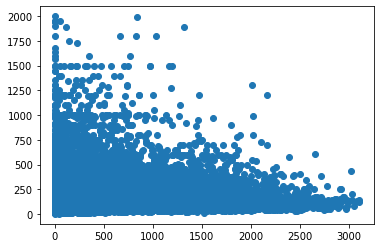

In [ ]:
plt.scatter(alldata_drop["Days_Int_L-F"],   alldata_drop.y)

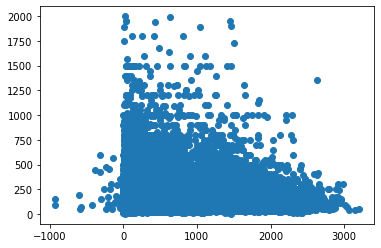

In [ ]:
alldata_drop["DateDelta_F-S"]=  alldata_drop["first_review_datetype"] -alldata_drop["host_since_datetype"]
alldata_drop["Days_Int_F-S"] = (alldata_drop["DateDelta_F-S"] / timedelta(days=1))
plt.scatter(alldata_drop["Days_Int_F-S"],   alldata_drop.y)

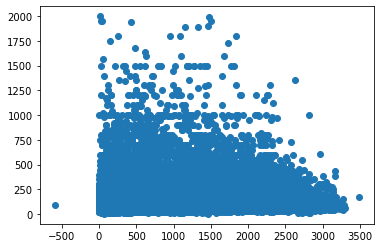

In [ ]:
alldata_drop["DateDelta_L-S"]=  alldata_drop["last_review_datetype"] -alldata_drop["host_since_datetype"]
alldata_drop["Days_Int_L-S"] = (alldata_drop["DateDelta_L-S"] / timedelta(days=1))
plt.scatter(alldata_drop["Days_Int_L-S"],   alldata_drop.y)

最終review日-oldest review日が値段に関係ありそう

In [ ]:
alldata_res=alldata_res.drop(['host_since'],axis=1)

print(alldata_res.shape)

alldata_res["first_review"]=alldata_res["first_review"].fillna("2016-01-14")#average
alldata_res["last_review"]=alldata_res["last_review"].fillna("2017-03-14")#average

print(alldata_res.shape)

alldata_res["first_review_datetype"]=pd.to_datetime(alldata_res["first_review"])
alldata_res["last_review_datetype"]=pd.to_datetime(alldata_res["last_review"])

print(alldata_res.shape)

alldata_res["DateDelta_L-F"]=alldata_res["last_review_datetype"] - alldata_res["first_review_datetype"]
alldata_res["Days_Int_L-F"] = (alldata_res["DateDelta_L-F"] / timedelta(days=1))

print(alldata_res.shape)

alldata_res=alldata_res.drop(['DateDelta_L-F','first_review_datetype','last_review_datetype'],axis=1)

#print(alldata_drop["first_review_datetype"].mean())
#print(alldata_drop["last_review_datetype"].mean())

(74111, 27)
(74111, 27)
(74111, 29)
(74111, 31)


In [ ]:
alldata_res.shape

(74111, 28)

In [ ]:
alldata_res.head(1)

,y,TrainFlag,id,accommodates,amenities,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,description,first_review,instant_bookable,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,property_type,review_scores_rating,room_type,zipcode,host_response_rate_num,response_rate_group,Days_Int_L-F
0,138.0,True,0,6,"{TV,""Wireless Internet"",Kitchen,""Free parking ...",2.0,Real Bed,1.0,4.0,flexible,LA,t,My place is meant for family and a few friends...,2016-07-27,f,2016-07-27,33.788931,-118.154761,The Penthouse,NaN,1,Apartment,60.0,Private room,90804,100.0,97100,0.0


In [ ]:
alldata_res.shape

(74111, 28)

###amenities

In [ ]:
type(alldata_res.amenities[0])

pandas.core.series.Series

In [ ]:
alldata_drop.amenities=alldata_drop.amenities.str.strip('{')
alldata_drop.amenities=alldata_drop.amenities.str.strip('}')
#alldata_drop.amenities=alldata_drop.amenities.str.strip('V')
#alldata_drop.head()
alldata_drop.amenities[0]
#for i in alldata_drop.amenities.index:
#  str_ame=alldata_drop.amenities[i].astype(str).strip('"')
#  str_ame
#print(alldata_drop.amenities[0].astype(str).strip('"'))

0    TV,"Wireless Internet",Kitchen,"Free parking o...
0    TV,"Cable TV","Wireless Internet","Air conditi...
Name: amenities, dtype: object

In [ ]:
alldata_amenities=alldata_drop.amenities.str.split(',', expand=True)
alldata_amenities

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76
0,TV,"""Wireless Internet""",Kitchen,"""Free parking on premises""",Washer,Dryer,"""Smoke detector""",None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,TV,"""Cable TV""",Internet,"""Wireless Internet""","""Air conditioning""",Kitchen,"""Free parking on premises""",Heating,Washer,Dryer,"""Smoke detector""","""Carbon monoxide detector""","""First aid kit""",Essentials,Shampoo,"""Lock on bedroom door""","""24-hour check-in""",Hangers,Iron,"""Laptop friendly workspace""","""translation missing: en.hosting_amenity_49""","""translation missing: en.hosting_amenity_50""",None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,TV,Internet,"""Wireless Internet""",Kitchen,"""Indoor fireplace""","""Buzzer/wireless intercom""",Heating,Washer,Dryer,"""Smoke detector""","""Carbon monoxide detector""","""First aid kit""","""Safety card""","""Fire extinguisher""",Essentials,Shampoo,"""Lock on bedroom door""","""24-hour check-in""",Hangers,"""Hair dryer""",Iron,"""Laptop friendly workspace""","""translation missing: en.hosting_amenity_49""","""translation missing: en.hosting_amenity_50""","""Self Check-In""",Keypad,Lockbox,Bathtub,"""Room-darkening shades""",None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3,TV,"""Cable TV""",Internet,"""Wireless Internet""","""Air conditioning""",Kitchen,"""Buzzer/wireless intercom""",Heating,Washer,Dryer,"""Smoke detector""","""Carbon monoxide detector""","""First aid kit""","""Safety card""",Essentials,Shampoo,"""Self Check-In""",Keypad,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4,TV,Internet,"""Wireless Internet""","""Air conditioning""",Kitchen,Elevator,"""Buzzer/wireless intercom""",Heating,Washer,Dryer,"""Smoke detector""","""Carbon monoxide detector""","""Safety card""","""Fire extinguisher""",Essentials,Shampoo,Hangers,"""Hair dryer""",None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18521,TV,"""Wireless Internet""","""Air conditioning""",Kitchen,"""Free parking on premises""",Heating,"""Smoke detector""","""Carbon monoxide detector""","""First aid kit""","""Fire extinguisher""",Essentials,Hangers,"""Hair dryer""",Iron,"""Laptop friendly workspace""","""Self Check-In""",Keypad,Bathtub,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,No

In [ ]:
amenities_set=set()
#set(alldata_amenities.iloc[i].values)
for i in alldata_amenities.index:
  amenities_set.update(tuple(alldata_amenities.iloc[i].values))

amenities_list=[]
for word in amenities_set:
  if type(word)== str:
    word=word.strip('"')
    word=word.strip("(s)")
    #print(word)
    amenities_list.append(word)
print(amenities_list,len(amenities_list))
  # word2=word.str.strip('"')
  # amenities_set2.update(word2)

['', 'Hot water', 'Pets allowed', 'Wide clearance to shower & toilet', 'Window guard', 'Private living room', 'Ethernet connection', 'Bathtub', 'Host greets you', 'Keypad', 'Hand soap', 'Pocket wifi', 'Hanger', 'Bathtub with shower chair', 'Family/kid friendly', 'Well-lit path to entrance', 'EV charger', 'Cooking basic', 'Self Check-In', 'Essential', 'Refrigerator', 'Ground floor acce', 'Air purifier', 'Wide doorway', 'Heating', 'Patio or balcony', 'Air conditioning', 'Extra pillows and blanket', 'translation missing: en.hosting_amenity_50', 'Other pet', 'Roll-in shower with chair', 'Oven', 'Washer / Dryer', 'Smoke detector', 'Suitable for event', 'Safety card', 'Bed linen', 'Accessible-height toilet', 'translation missing: en.hosting_amenity_49', 'Handheld shower head', 'Private bathroom', 'Internet', 'Baby monitor', 'Cable TV', 'Wide clearance to bed', 'Pack ’n Play/travel crib', 'Stove', 'Hot tub', 'Wide hallway clearance', 'Single level home', 'Elevator in building', 'Lock on bedro

In [ ]:
#for i in alldata_drop.index:
#if alldata_drop.amenities.str.contains("TV") == True:
#  alldata_drop["hasTV"]=True
#else:
#  alldata_drop["hasTV"]=False
#alldata_drop

#alldata_drop["hasTV"]=alldata_drop.amenities.str.contains("TV")
#alldata_drop

In [ ]:
#amenities_list=list(amenities_set)
for i in amenities_list:
  alldata_drop["has_"+i]=alldata_drop.amenities.str.contains(i)
alldata_drop

,y,TrainFlag,id,accommodates,amenities,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,description,first_review,host_has_profile_pic,host_identity_verified,host_since,instant_bookable,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,property_type,review_scores_rating,room_type,zipcode,host_response_rate_num,response_rate_group,first_review_datetype,last_review_datetype,host_since_datetype,DateDelta_L-F,Days_Int_L-F,DateDelta_F-S,Days_Int_F-S,DateDelta_L-S,Days_Int_L-S,has_,...,has_Doorman Entry,has_Carbon monoxide detector,has_High chair,has_Babysitter recommendation,has_Washer,has_Disabled parking spot,has_Accessible-height bed,has_Grab-rails for shower and toilet,has_Outlet cover,has_Cleaning before checkout,has_Free parking on street,has_Long term stays allowed,has_Room-darkening shade,has_Fireplace guard,has_24-hour check-in,has_Indoor fireplace,has_Pool,has_Wide entryway,has_Flat,has_Firm matre,has_Dishes and silverware,has_Firm mattre,has_Hand or paper towel,has_Toilet paper,has_Fire extinguisher,has_Cat,has_Buzzer/wireless intercom,has_Waterfront,has_Table corner guard,has_Ski in/Ski out,has_Wireless Internet,has_BBQ grill,has_Smoking allowed,has_First aid kit,has_Luggage dropoff allowed,has_Doorman,has_Path to entrance lit at night,has_Shampoo,has_Wheelchair accessible,has_Breakfast
0,138.0,True,0,6,"TV,""Wireless Internet"",Kitchen,""Free parking o...",2.0,Real Bed,1.0,4.0,flexible,LA,t,My place is meant for family and a few friends...,2016-07-27,t,f,2016-07-13,f,2016-07-27,33.788931,-118.154761,The Penthouse,NaN,1,Apartment,60.0,Private room,90804,100.0,97100,2016-07-27,2016-07-27,2016-07-13,0 days,0.0,14 days,14.0,14 days,14.0,True,...,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
1,42.0,True,1,2,"TV,""Cable TV"",Internet,""Wireless Internet"",""Ai...",1.0,Real Bed,1.0,1.0,strict,DC,t,This is a new listing for a lovely guest bedro...,2016-09-12,t,t,2015-12-30,f,2017-03-31,38.934810,-76.978190,Guest Bedroom in Brookland,Brookland,9,House,100.0,Private room,20018,100.0,97100,2016-09-12,2017-03-31,2015-12-30,200 days,200.0,257 days,257.0,457 days,457.0,True,...,False,True,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,True,False,False
2,65.0,True,2,2,"TV,Internet,""Wireless Internet"",Kitchen,""Indoo...",2.0,Real Bed,1.0,1.0,strict,NYC,t,We're looking forward to your stay at our apt....,2016-06-15,t,f,2016-05-21,t,2017-08-13,40.695118,-73.926240,Clean Modern Room in Lux Apt 1 Block From J Train,Bushwick,27,Apartment,83.0,Private room,NaN,100.0,97100,2016-06-15,2017-08-13,2016-05-21,424 days,424.0,25 days,25.0,449 days,449.0,True,...,False,True,False,False,True,False,False,False,False,False,False,False,True,False,True,True,False,False,False,False,False,False,False,False,True,False,True,False,False,False,True,False,False,True,False,False,False,True,False,False
3,166.0,True,3,2,"TV,""Cable TV"",Internet,""Wireless Internet"",""Ai...",1.0,Real Bed,1.0,1.0,strict,SF,t,BEST CITY VIEWS - - ROOF DECK W/ BBQ & WiFi - ...,2014-03-15,t,t,2012-06-19,t,2017-09-03,37.796728,-122.411906,BEST views + reviews! 5/5 stars*****,Nob Hill,38,Apartment,95.0,Private room,94133,100.0,97100,2014-03-15,2017-09-03,2012-06-19,1268 days,1268.0,634 days,634.0,1902 days,1902.0,True,...,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,True,False,False,False,True,False,False
4,165.0,True,4,2,"TV,Internet,""Wireless Internet"",""Air condition...",1.0,Real Bed,1.0,1.0,strict,NYC,t,Charming Apartment on the upper west side of M

In [ ]:
alldata_res.shape

(74111, 28)

本当のdataframeに適用

In [ ]:
alldata_res.amenities=alldata_res.amenities.str.strip('{')
alldata_res.amenities=alldata_res.amenities.str.strip('}')

alldata_amenities_res=alldata_res.amenities.str.split(',', expand=True)
amenities_set_res=set()

for i in alldata_amenities_res.index:
  amenities_set_res.update(tuple(alldata_amenities_res.iloc[i].values))

amenities_list=[]
for word in amenities_set_res:
  if type(word)== str:
    word=word.strip('"')
    word=word.strip('(s)')
    #print(word)
    amenities_list.append(word)
print(amenities_list,len(amenities_list))
  # word2=word.str.strip('"')
  # amenities_set2.update(word2)
for i in amenities_list:
  alldata_res["has_"+i]=alldata_res.amenities.str.contains(i)

['', 'Hot water', 'Pets allowed', 'Wide clearance to shower & toilet', 'Window guard', 'Private living room', 'Ethernet connection', 'Bathtub', 'Host greets you', 'Keypad', 'Hand soap', 'Pocket wifi', 'Hanger', 'Bathtub with shower chair', 'Family/kid friendly', 'Well-lit path to entrance', 'EV charger', 'Cooking basic', 'Self Check-In', 'Essential', 'Refrigerator', 'Ground floor acce', 'Air purifier', 'Wide doorway', 'Heating', 'Patio or balcony', 'Air conditioning', 'Extra pillows and blanket', 'translation missing: en.hosting_amenity_50', 'Other pet', 'Roll-in shower with chair', 'Oven', 'Washer / Dryer', 'Smoke detector', 'Suitable for event', 'Safety card', 'Bed linen', 'Accessible-height toilet', 'translation missing: en.hosting_amenity_49', 'Handheld shower head', 'Private bathroom', 'Internet', 'Baby monitor', 'Cable TV', 'Wide clearance to bed', 'Pack ’n Play/travel crib', 'Hot tub', 'Stove', 'Wide hallway clearance', 'Single level home', 'Elevator in building', 'Lock on bedro

In [ ]:
alldata_res.shape

(74111, 158)

In [ ]:
alldata_res=alldata_res.drop(["amenities","has_","has_translation missing: en.hosting_amenity_49"],axis=1)
alldata_res.head()

,y,TrainFlag,id,accommodates,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,description,first_review,instant_bookable,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,property_type,review_scores_rating,room_type,zipcode,host_response_rate_num,response_rate_group,Days_Int_L-F,has_Hot water,has_Pets allowed,has_Wide clearance to shower & toilet,has_Window guard,has_Private living room,has_Ethernet connection,has_Bathtub,has_Host greets you,has_Keypad,has_Hand soap,has_Pocket wifi,has_Hanger,has_Bathtub with shower chair,...,has_Doorman Entry,has_Carbon monoxide detector,has_High chair,has_Babysitter recommendation,has_Washer,has_Disabled parking spot,has_Accessible-height bed,has_Grab-rails for shower and toilet,has_Outlet cover,has_Cleaning before checkout,has_Free parking on street,has_Long term stays allowed,has_Room-darkening shade,has_Fireplace guard,has_24-hour check-in,has_Indoor fireplace,has_Pool,has_Wide entryway,has_Flat,has_Firm matre,has_Dishes and silverware,has_Firm mattre,has_Hand or paper towel,has_Toilet paper,has_Fire extinguisher,has_Cat,has_Buzzer/wireless intercom,has_Waterfront,has_Table corner guard,has_Ski in/Ski out,has_Wireless Internet,has_BBQ grill,has_Smoking allowed,has_First aid kit,has_Luggage dropoff allowed,has_Doorman,has_Path to entrance lit at night,has_Shampoo,has_Wheelchair accessible,has_Breakfast
0,138.0,True,0,6,2.0,Real Bed,1.0,4.0,flexible,LA,t,My place is meant for family and a few friends...,2016-07-27,f,2016-07-27,33.788931,-118.154761,The Penthouse,NaN,1,Apartment,60.0,Private room,90804,100.0,97100,0.0,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
1,42.0,True,1,2,1.0,Real Bed,1.0,1.0,strict,DC,t,This is a new listing for a lovely guest bedro...,2016-09-12,f,2017-03-31,38.934810,-76.978190,Guest Bedroom in Brookland,Brookland,9,House,100.0,Private room,20018,100.0,97100,200.0,False,False,False,False,False,False,False,False,False,False,False,True,False,...,False,True,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,True,False,False
2,65.0,True,2,2,2.0,Real Bed,1.0,1.0,strict,NYC,t,We're looking forward to your stay at our apt....,2016-06-15,t,2017-08-13,40.695118,-73.926240,Clean Modern Room in Lux Apt 1 Block From J Train,Bushwick,27,Apartment,83.0,Private room,NaN,100.0,97100,424.0,False,False,False,False,False,False,True,False,True,False,False,True,False,...,False,True,False,False,True,False,False,False,False,False,False,False,True,False,True,True,False,False,False,False,False,False,False,False,True,False,True,False,False,False,True,False,False,True,False,False,False,True,False,False
3,166.0,True,3,2,1.0,Real Bed,1.0,1.0,strict,SF,t,BEST CITY VIEWS - - ROOF DECK W/ BBQ & WiFi - ...,2014-03-15,t,2017-09-03,37.796728,-122.411906,BEST views + reviews! 5/5 stars*****,Nob Hill,38,Apartment,95.0,Private room,94133,100.0,97100,1268.0,False,False,False,False,False,False,False,False,True,False,False,False,False,...,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,True,False,False,False,True,False,False
4,165.0,True,4,2,1.0,Real Bed,1.0,1.0,strict,NYC,t,Charming Apartment on the upper west side of M...,2015-08-05,f,2017-09-10,40.785050,-73.974691,Charming 1-bedroom - UWS Manhattan,Upper West Side,5,Apartment,100.0,Entire home/apt,10024,100.0,97100,767.0,False,False,False,False,False,False,False,False,False,False,False,True,False,...,False,True,False,False,True,False,False,False,Fal

In [ ]:
#欠損値がある変数だけが降順に並び替え
alldata_res.isnull().sum()[alldata_res.isnull().sum()>0].sort_values(ascending = False)

y                18528
neighbourhood     6872
zipcode            966
bathrooms          200
dtype: int64

###zipcode

In [ ]:
# alldata_res.zipcode.value_counts

In [ ]:
# alldata_drop=alldata_drop.dropna(subset=['zipcode'])
# #欠損値がある変数だけが降順に並び替え
# alldata_drop.isnull().sum()[alldata_drop.isnull().sum()>0].sort_values(ascending = False)

In [ ]:
# g_zip5=[]
# g_zip4=[]
# g_zip3=[]
# g_zip2=[]
# for i in alldata_drop.index:
#   g_zip5.append(alldata_drop.zipcode.values[i][0:5])#
#   g_zip4.append(alldata_drop.zipcode.values[i][0:4])#
#   g_zip3.append(alldata_drop.zipcode.values[i][0:3])#
#   g_zip2.append(alldata_drop.zipcode.values[i][0:2])#
#   #print(g)
# alldata_drop["Global_zip5"]=g_zip5
# alldata_drop["Global_zip4"]=g_zip4
# alldata_drop["Global_zip3"]=g_zip3
# alldata_drop["Global_zip2"]=g_zip2
# # alldata_drop.head()

In [ ]:
# plt.scatter(alldata_drop.Global_zip5, alldata_drop.y)
# plt.show()
# plt.scatter(alldata_drop.Global_zip4, alldata_drop.y)
# plt.show()
# plt.scatter(alldata_drop.Global_zip3, alldata_drop.y)
# plt.show()
# plt.scatter(alldata_drop.Global_zip2, alldata_drop.y)
# plt.show()

In [ ]:
# alldata_drop.Global_zip4.unique()

In [ ]:
# #pd.set_option('display.max_rows', None)
# alldata_drop.groupby("Global_zip4")["Global_zip4"].count()

In [ ]:
#zipcode関係ありそう 4桁でいいかな

In [ ]:
# alldata_res.city.unique()

LA:90台
DC:20台
NY:10台
SF:94台
Chicago:60台
Boston:02台

In [ ]:
# alldata_drop.info()

In [ ]:
# # alldata_res.loc[(alldata_res.city =='LA') & (alldata_res.zipcode.isnull()==True),"zipcode"]="9080"
# # alldata_resloc[(alldata_res.city=='DC') &  (alldata_res.zipcode.isnull()==True)].zipcode="2000"
# # alldata_res.loc[(alldata_res.city=='NYC') & (alldata_res.zipcode.isnull()==True),"zipcode"]="1001"
# # alldata_resloc[(alldata_res.city=='SF') &  (alldata_res.zipcode.isnull()==True)].zipcode="9411"
# # alldata_resloc[(alldata_res.city=='Chicago') & (alldata_res.zipcode.isnull()==True)].zipcode="6061"
# # alldata_resloc[(alldata_res.city=='Boston') & (alldata_res.zipcode.isnull()==True)].zipcode="0211"


# zipcode_list=["9080","2000", "1001", "9411", "6061", "0211"]

# for i in range(len(alldata_res.city.unique())):
#   alldata_res.loc[(alldata_res.city == alldata_res.city.unique()[i]) & (alldata_res.zipcode.isnull()==True),"zipcode"]=zipcode_list[i]

# g_zip4_res=[]
# for i in alldata_res.index:
#   g_zip4_res.append(alldata_res.zipcode.values[i][0:4])#

# alldata_res["Global_zip4"]=g_zip4_res
# alldata_res=alldata_res.drop(['zipcode'], axis=1)

# alldata_res.head()

In [ ]:
# alldata_res.zipcode.isnull()

###bathrooms

In [ ]:
# sns.jointplot(alldata_res.accommodates, alldata_res.bathrooms, kind="hex")

(array([4.070e+02, 6.190e+04, 7.936e+03, 2.633e+03, 4.290e+02, 4.020e+02,
        1.110e+02, 2.400e+01, 2.200e+01, 4.700e+01]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ]),
 <a list of 10 Patch objects>)

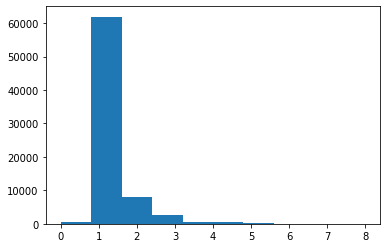

In [ ]:
plt.hist(alldata_res.bathrooms)

bathroomの欠損値は1で穴埋め

In [ ]:
alldata_res.bathrooms=alldata_res.bathrooms.fillna(alldata_res.bathrooms.mean())

In [ ]:
#欠損値がある変数だけが降順に並び替え
alldata_res.isnull().sum()[alldata_res.isnull().sum()>0].sort_values(ascending = False)

y                18528
neighbourhood     6872
zipcode            966
dtype: int64

###description,nameは保留

###消したり整理

In [ ]:
alldata_res.head(1)

,y,TrainFlag,id,accommodates,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,description,first_review,instant_bookable,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,property_type,review_scores_rating,room_type,zipcode,host_response_rate_num,response_rate_group,Days_Int_L-F,has_Hot water,has_Pets allowed,has_Wide clearance to shower & toilet,has_Window guard,has_Private living room,has_Ethernet connection,has_Bathtub,has_Host greets you,has_Keypad,has_Hand soap,has_Pocket wifi,has_Hanger,has_Bathtub with shower chair,...,has_Doorman Entry,has_Carbon monoxide detector,has_High chair,has_Babysitter recommendation,has_Washer,has_Disabled parking spot,has_Accessible-height bed,has_Grab-rails for shower and toilet,has_Outlet cover,has_Cleaning before checkout,has_Free parking on street,has_Long term stays allowed,has_Room-darkening shade,has_Fireplace guard,has_24-hour check-in,has_Indoor fireplace,has_Pool,has_Wide entryway,has_Flat,has_Firm matre,has_Dishes and silverware,has_Firm mattre,has_Hand or paper towel,has_Toilet paper,has_Fire extinguisher,has_Cat,has_Buzzer/wireless intercom,has_Waterfront,has_Table corner guard,has_Ski in/Ski out,has_Wireless Internet,has_BBQ grill,has_Smoking allowed,has_First aid kit,has_Luggage dropoff allowed,has_Doorman,has_Path to entrance lit at night,has_Shampoo,has_Wheelchair accessible,has_Breakfast
0,138.0,True,0,6,2.0,Real Bed,1.0,4.0,flexible,LA,t,My place is meant for family and a few friends...,2016-07-27,f,2016-07-27,33.788931,-118.154761,The Penthouse,NaN,1,Apartment,60.0,Private room,90804,100.0,97100,0.0,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False


In [ ]:
alldata_res=alldata_res.drop(['id','first_review','last_review', 'description', 'name'], axis=1)

In [ ]:
alldata_res.head()

,y,TrainFlag,accommodates,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,instant_bookable,latitude,longitude,neighbourhood,number_of_reviews,property_type,review_scores_rating,room_type,zipcode,host_response_rate_num,response_rate_group,Days_Int_L-F,has_Hot water,has_Pets allowed,has_Wide clearance to shower & toilet,has_Window guard,has_Private living room,has_Ethernet connection,has_Bathtub,has_Host greets you,has_Keypad,has_Hand soap,has_Pocket wifi,has_Hanger,has_Bathtub with shower chair,has_Family/kid friendly,has_Well-lit path to entrance,has_EV charger,has_Cooking basic,has_Self Check-In,...,has_Doorman Entry,has_Carbon monoxide detector,has_High chair,has_Babysitter recommendation,has_Washer,has_Disabled parking spot,has_Accessible-height bed,has_Grab-rails for shower and toilet,has_Outlet cover,has_Cleaning before checkout,has_Free parking on street,has_Long term stays allowed,has_Room-darkening shade,has_Fireplace guard,has_24-hour check-in,has_Indoor fireplace,has_Pool,has_Wide entryway,has_Flat,has_Firm matre,has_Dishes and silverware,has_Firm mattre,has_Hand or paper towel,has_Toilet paper,has_Fire extinguisher,has_Cat,has_Buzzer/wireless intercom,has_Waterfront,has_Table corner guard,has_Ski in/Ski out,has_Wireless Internet,has_BBQ grill,has_Smoking allowed,has_First aid kit,has_Luggage dropoff allowed,has_Doorman,has_Path to entrance lit at night,has_Shampoo,has_Wheelchair accessible,has_Breakfast
0,138.0,True,6,2.0,Real Bed,1.0,4.0,flexible,LA,t,f,33.788931,-118.154761,NaN,1,Apartment,60.0,Private room,90804,100.0,97100,0.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
1,42.0,True,2,1.0,Real Bed,1.0,1.0,strict,DC,t,f,38.934810,-76.978190,Brookland,9,House,100.0,Private room,20018,100.0,97100,200.0,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,...,False,True,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,True,False,False
2,65.0,True,2,2.0,Real Bed,1.0,1.0,strict,NYC,t,t,40.695118,-73.926240,Bushwick,27,Apartment,83.0,Private room,NaN,100.0,97100,424.0,False,False,False,False,False,False,True,False,True,False,False,True,False,False,False,False,False,True,...,False,True,False,False,True,False,False,False,False,False,False,False,True,False,True,True,False,False,False,False,False,False,False,False,True,False,True,False,False,False,True,False,False,True,False,False,False,True,False,False
3,166.0,True,2,1.0,Real Bed,1.0,1.0,strict,SF,t,t,37.796728,-122.411906,Nob Hill,38,Apartment,95.0,Private room,94133,100.0,97100,1268.0,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,...,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,True,False,False,False,True,False,False
4,165.0,True,2,1.0,Real Bed,1.0,1.0,strict,NYC,t,f,40.785050,-73.974691,Upper West Side,5,Apartment,100.0,Entire home/apt,10024,100.0,97100,767.0,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,...,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False


###目的関数の分布

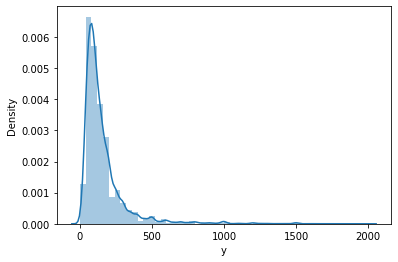

In [ ]:
sns.distplot(alldata_res.y)

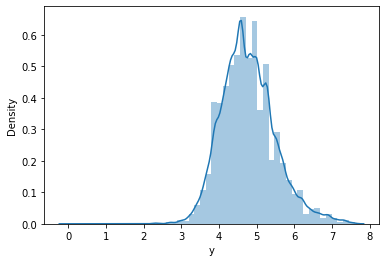

In [ ]:
#対数変換後
sns.distplot(np.log(alldata_res.y))

In [ ]:
#log_y= np.log(alldata_res.y)

###longitude

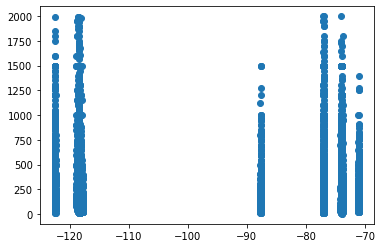

In [ ]:
plt.scatter(alldata_res.longitude, alldata_res.y)

In [ ]:
#longitude_list=[-120, -90, -80, -70]


alldata_res.loc[alldata_res.longitude <-110,"longitude_group"]="-120"
alldata_res.loc[(alldata_res.longitude >-90) & (alldata_res.longitude <-80),"longitude_group"]="-90"
alldata_res.loc[(alldata_res.longitude >-80) & (alldata_res.longitude <-72.5),"longitude_group"]="-80"
alldata_res.loc[alldata_res.longitude >=-72.5 ,"longitude_group"]="-70"

alldata_res.drop(["longitude"],axis=1)

alldata_res.head()

,y,TrainFlag,accommodates,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,instant_bookable,latitude,longitude,neighbourhood,number_of_reviews,property_type,review_scores_rating,room_type,zipcode,host_response_rate_num,response_rate_group,Days_Int_L-F,has_Hot water,has_Pets allowed,has_Wide clearance to shower & toilet,has_Window guard,has_Private living room,has_Ethernet connection,has_Bathtub,has_Host greets you,has_Keypad,has_Hand soap,has_Pocket wifi,has_Hanger,has_Bathtub with shower chair,has_Family/kid friendly,has_Well-lit path to entrance,has_EV charger,has_Cooking basic,has_Self Check-In,...,has_Carbon monoxide detector,has_High chair,has_Babysitter recommendation,has_Washer,has_Disabled parking spot,has_Accessible-height bed,has_Grab-rails for shower and toilet,has_Outlet cover,has_Cleaning before checkout,has_Free parking on street,has_Long term stays allowed,has_Room-darkening shade,has_Fireplace guard,has_24-hour check-in,has_Indoor fireplace,has_Pool,has_Wide entryway,has_Flat,has_Firm matre,has_Dishes and silverware,has_Firm mattre,has_Hand or paper towel,has_Toilet paper,has_Fire extinguisher,has_Cat,has_Buzzer/wireless intercom,has_Waterfront,has_Table corner guard,has_Ski in/Ski out,has_Wireless Internet,has_BBQ grill,has_Smoking allowed,has_First aid kit,has_Luggage dropoff allowed,has_Doorman,has_Path to entrance lit at night,has_Shampoo,has_Wheelchair accessible,has_Breakfast,longitude_group
0,138.0,True,6,2.0,Real Bed,1.0,4.0,flexible,LA,t,f,33.788931,-118.154761,NaN,1,Apartment,60.0,Private room,90804,100.0,97100,0.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,-120
1,42.0,True,2,1.0,Real Bed,1.0,1.0,strict,DC,t,f,38.934810,-76.978190,Brookland,9,House,100.0,Private room,20018,100.0,97100,200.0,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,...,True,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,True,False,False,-80
2,65.0,True,2,2.0,Real Bed,1.0,1.0,strict,NYC,t,t,40.695118,-73.926240,Bushwick,27,Apartment,83.0,Private room,NaN,100.0,97100,424.0,False,False,False,False,False,False,True,False,True,False,False,True,False,False,False,False,False,True,...,True,False,False,True,False,False,False,False,False,False,False,True,False,True,True,False,False,False,False,False,False,False,False,True,False,True,False,False,False,True,False,False,True,False,False,False,True,False,False,-80
3,166.0,True,2,1.0,Real Bed,1.0,1.0,strict,SF,t,t,37.796728,-122.411906,Nob Hill,38,Apartment,95.0,Private room,94133,100.0,97100,1268.0,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,...,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,True,False,False,False,True,False,False,-120
4,165.0,True,2,1.0,Real Bed,1.0,1.0,strict,NYC,t,f,40.785050,-73.974691,Upper West Side,5,Apartment,100.0,Entire home/apt,10024,100.0,97100,767.0,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,...,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,-80


###latitude

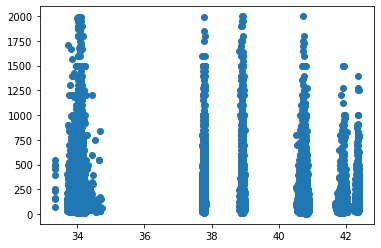

In [ ]:
plt.scatter(alldata_res.latitude, alldata_res.y)

In [ ]:
#latitude_list=[34, 38, 41, 42]


alldata_res.loc[alldata_res.latitude <36,"latitude_group"]="34"
alldata_res.loc[(alldata_res.latitude >36) & (alldata_res.latitude <40),"latitude_group"]="38"
alldata_res.loc[(alldata_res.latitude >40) & (alldata_res.latitude <41.3),"latitude_group"]="41"
alldata_res.loc[alldata_res.latitude >=41.3 ,"latitude_group"]="42"

alldata_res.drop(["latitude"],axis=1)

alldata_res.head()

,y,TrainFlag,accommodates,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,instant_bookable,latitude,longitude,neighbourhood,number_of_reviews,property_type,review_scores_rating,room_type,zipcode,host_response_rate_num,response_rate_group,Days_Int_L-F,has_Hot water,has_Pets allowed,has_Wide clearance to shower & toilet,has_Window guard,has_Private living room,has_Ethernet connection,has_Bathtub,has_Host greets you,has_Keypad,has_Hand soap,has_Pocket wifi,has_Hanger,has_Bathtub with shower chair,has_Family/kid friendly,has_Well-lit path to entrance,has_EV charger,has_Cooking basic,has_Self Check-In,...,has_High chair,has_Babysitter recommendation,has_Washer,has_Disabled parking spot,has_Accessible-height bed,has_Grab-rails for shower and toilet,has_Outlet cover,has_Cleaning before checkout,has_Free parking on street,has_Long term stays allowed,has_Room-darkening shade,has_Fireplace guard,has_24-hour check-in,has_Indoor fireplace,has_Pool,has_Wide entryway,has_Flat,has_Firm matre,has_Dishes and silverware,has_Firm mattre,has_Hand or paper towel,has_Toilet paper,has_Fire extinguisher,has_Cat,has_Buzzer/wireless intercom,has_Waterfront,has_Table corner guard,has_Ski in/Ski out,has_Wireless Internet,has_BBQ grill,has_Smoking allowed,has_First aid kit,has_Luggage dropoff allowed,has_Doorman,has_Path to entrance lit at night,has_Shampoo,has_Wheelchair accessible,has_Breakfast,longitude_group,latitude_group
0,138.0,True,6,2.0,Real Bed,1.0,4.0,flexible,LA,t,f,33.788931,-118.154761,NaN,1,Apartment,60.0,Private room,90804,100.0,97100,0.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,-120,34
1,42.0,True,2,1.0,Real Bed,1.0,1.0,strict,DC,t,f,38.934810,-76.978190,Brookland,9,House,100.0,Private room,20018,100.0,97100,200.0,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,True,False,False,-80,38
2,65.0,True,2,2.0,Real Bed,1.0,1.0,strict,NYC,t,t,40.695118,-73.926240,Bushwick,27,Apartment,83.0,Private room,NaN,100.0,97100,424.0,False,False,False,False,False,False,True,False,True,False,False,True,False,False,False,False,False,True,...,False,False,True,False,False,False,False,False,False,False,True,False,True,True,False,False,False,False,False,False,False,False,True,False,True,False,False,False,True,False,False,True,False,False,False,True,False,False,-80,41
3,166.0,True,2,1.0,Real Bed,1.0,1.0,strict,SF,t,t,37.796728,-122.411906,Nob Hill,38,Apartment,95.0,Private room,94133,100.0,97100,1268.0,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,...,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,True,False,False,False,True,False,False,-120,38
4,165.0,True,2,1.0,Real Bed,1.0,1.0,strict,NYC,t,f,40.785050,-73.974691,Upper West Side,5,Apartment,100.0,Entire home/apt,10024,100.0,97100,767.0,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,-80,41


###cancellation_policy

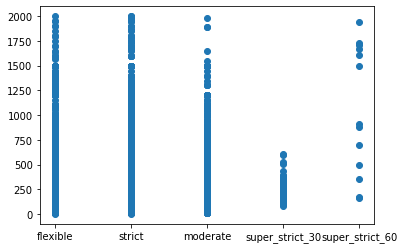

In [ ]:
plt.scatter(alldata_res.cancellation_policy, alldata_res.y)

In [ ]:
# sns.jointplot("cancellation_policy", "y", data=alldata_res, kind="hex")
alldata_res.groupby("cancellation_policy").y.mean()

cancellation_policy
flexible            149.785029
moderate            141.202828
strict              177.708076
super_strict_30     260.038462
super_strict_60    1062.461538
Name: y, dtype: float64

In [ ]:
alldata_res.groupby("cancellation_policy").y.median()

cancellation_policy
flexible            99.0
moderate           105.0
strict             129.0
super_strict_30    249.0
super_strict_60    911.0
Name: y, dtype: float64

###追加追加220117

In [ ]:
# alldata_res=alldata_res.drop(['longitude','latitude'], axis=1)
alldata_res=alldata_res.drop(['zipcode'], axis=1)

###instant_bookable

In [ ]:
alldata_res.groupby("instant_bookable").y.mean()

instant_bookable
f    162.805405
t    152.712832
Name: y, dtype: float64

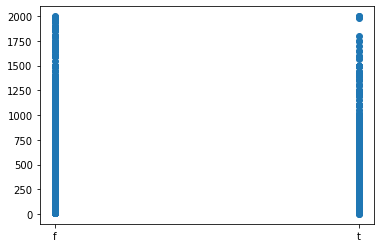

In [ ]:
plt.scatter(alldata_res.instant_bookable, alldata_res.y)

###number_of_reviews

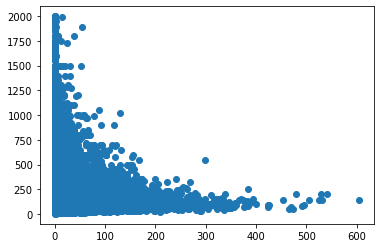

In [ ]:
plt.scatter(alldata_res.number_of_reviews, alldata_res.y)

###response_rate

In [ ]:
# plt.scatter(alldata_res.host_response_rate_num,alldata_res.y)

In [ ]:
# alldata_res.info()

###カテゴリ変数への変換

In [ ]:
alldata_res
alldata_ctg=pd.get_dummies(alldata_res, drop_first=True)
alldata_ctg

,y,TrainFlag,accommodates,bathrooms,bedrooms,beds,latitude,longitude,number_of_reviews,review_scores_rating,host_response_rate_num,Days_Int_L-F,has_Hot water,has_Pets allowed,has_Wide clearance to shower & toilet,has_Window guard,has_Private living room,has_Ethernet connection,has_Bathtub,has_Host greets you,has_Keypad,has_Hand soap,has_Pocket wifi,has_Hanger,has_Bathtub with shower chair,has_Family/kid friendly,has_Well-lit path to entrance,has_EV charger,has_Cooking basic,has_Self Check-In,has_Essential,has_Refrigerator,has_Ground floor acce,has_Air purifier,has_Wide doorway,has_Heating,has_Patio or balcony,has_Air conditioning,has_Extra pillows and blanket,has_translation missing: en.hosting_amenity_50,...,property_type_Casa particular,property_type_Castle,property_type_Cave,property_type_Chalet,property_type_Condominium,property_type_Dorm,property_type_Earth House,property_type_Guest suite,property_type_Guesthouse,property_type_Hostel,property_type_House,property_type_Hut,property_type_In-law,property_type_Island,property_type_Lighthouse,property_type_Loft,property_type_Other,property_type_Parking Space,property_type_Serviced apartment,property_type_Tent,property_type_Timeshare,property_type_Tipi,property_type_Townhouse,property_type_Train,property_type_Treehouse,property_type_Vacation home,property_type_Villa,property_type_Yurt,room_type_Private room,room_type_Shared room,response_rate_group_050,response_rate_group_5075,response_rate_group_7597,response_rate_group_97100,longitude_group_-70,longitude_group_-80,longitude_group_-90,latitude_group_38,latitude_group_41,latitude_group_42
0,138.0,True,6,2.0,1.0,4.0,33.788931,-118.154761,1,60.0,100.0,0.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
1,42.0,True,2,1.0,1.0,1.0,38.934810,-76.978190,9,100.0,100.0,200.0,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,True,False,True,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0
2,65.0,True,2,2.0,1.0,1.0,40.695118,-73.926240,27,83.0,100.0,424.0,False,False,False,False,False,False,True,False,True,False,False,True,False,False,False,False,False,True,True,False,False,False,False,True,False,False,False,True,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0
3,166.0,True,2,1.0,1.0,1.0,37.796728,-122.411906,38,95.0,100.0,1268.0,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,True,False,False,False,False,True,False,True,False,False,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0
4,165.0,True,2,1.0,1.0,1.0,40.785050,-73.974691,5,100.0,100.0,767.0,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,True,False,False,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18523,NaN,False,4,1.0,2.0,2.0,40.734555,-73.954892,0,96.0,100.0,425.0,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,True,False,False,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0
18524,NaN,False,2,1.0,2.0,1.0,41.945939,-87.672018,9,90.0,100.0,85.0,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False

###train testに分ける

In [ ]:
train=alldata_ctg.loc[alldata_ctg.TrainFlag]
train=train.drop("TrainFlag",axis=1)
train.head()

,y,accommodates,bathrooms,bedrooms,beds,latitude,longitude,number_of_reviews,review_scores_rating,host_response_rate_num,Days_Int_L-F,has_Hot water,has_Pets allowed,has_Wide clearance to shower & toilet,has_Window guard,has_Private living room,has_Ethernet connection,has_Bathtub,has_Host greets you,has_Keypad,has_Hand soap,has_Pocket wifi,has_Hanger,has_Bathtub with shower chair,has_Family/kid friendly,has_Well-lit path to entrance,has_EV charger,has_Cooking basic,has_Self Check-In,has_Essential,has_Refrigerator,has_Ground floor acce,has_Air purifier,has_Wide doorway,has_Heating,has_Patio or balcony,has_Air conditioning,has_Extra pillows and blanket,has_translation missing: en.hosting_amenity_50,has_Other pet,...,property_type_Casa particular,property_type_Castle,property_type_Cave,property_type_Chalet,property_type_Condominium,property_type_Dorm,property_type_Earth House,property_type_Guest suite,property_type_Guesthouse,property_type_Hostel,property_type_House,property_type_Hut,property_type_In-law,property_type_Island,property_type_Lighthouse,property_type_Loft,property_type_Other,property_type_Parking Space,property_type_Serviced apartment,property_type_Tent,property_type_Timeshare,property_type_Tipi,property_type_Townhouse,property_type_Train,property_type_Treehouse,property_type_Vacation home,property_type_Villa,property_type_Yurt,room_type_Private room,room_type_Shared room,response_rate_group_050,response_rate_group_5075,response_rate_group_7597,response_rate_group_97100,longitude_group_-70,longitude_group_-80,longitude_group_-90,latitude_group_38,latitude_group_41,latitude_group_42
0,138.0,6,2.0,1.0,4.0,33.788931,-118.154761,1,60.0,100.0,0.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
1,42.0,2,1.0,1.0,1.0,38.934810,-76.978190,9,100.0,100.0,200.0,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,True,False,True,False,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0
2,65.0,2,2.0,1.0,1.0,40.695118,-73.926240,27,83.0,100.0,424.0,False,False,False,False,False,False,True,False,True,False,False,True,False,False,False,False,False,True,True,False,False,False,False,True,False,False,False,True,False,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0
3,166.0,2,1.0,1.0,1.0,37.796728,-122.411906,38,95.0,100.0,1268.0,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,True,False,False,False,False,True,False,True,False,False,False,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0
4,165.0,2,1.0,1.0,1.0,40.785050,-73.974691,5,100.0,100.0,767.0,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,True,False,False,False,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0


In [ ]:
train.columns

Index(['y', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'latitude',
       'longitude', 'number_of_reviews', 'review_scores_rating',
       'host_response_rate_num',
       ...
       'response_rate_group_050', 'response_rate_group_5075',
       'response_rate_group_7597', 'response_rate_group_97100',
       'longitude_group_-70', 'longitude_group_-80', 'longitude_group_-90',
       'latitude_group_38', 'latitude_group_41', 'latitude_group_42'],
      dtype='object', length=200)

In [ ]:
test=alldata_ctg.loc[~alldata_ctg.TrainFlag]
test=test[test.columns[1:]]
test=test.drop("TrainFlag",axis=1)
test.head()

,accommodates,bathrooms,bedrooms,beds,latitude,longitude,number_of_reviews,review_scores_rating,host_response_rate_num,Days_Int_L-F,has_Hot water,has_Pets allowed,has_Wide clearance to shower & toilet,has_Window guard,has_Private living room,has_Ethernet connection,has_Bathtub,has_Host greets you,has_Keypad,has_Hand soap,has_Pocket wifi,has_Hanger,has_Bathtub with shower chair,has_Family/kid friendly,has_Well-lit path to entrance,has_EV charger,has_Cooking basic,has_Self Check-In,has_Essential,has_Refrigerator,has_Ground floor acce,has_Air purifier,has_Wide doorway,has_Heating,has_Patio or balcony,has_Air conditioning,has_Extra pillows and blanket,has_translation missing: en.hosting_amenity_50,has_Other pet,has_Roll-in shower with chair,...,property_type_Casa particular,property_type_Castle,property_type_Cave,property_type_Chalet,property_type_Condominium,property_type_Dorm,property_type_Earth House,property_type_Guest suite,property_type_Guesthouse,property_type_Hostel,property_type_House,property_type_Hut,property_type_In-law,property_type_Island,property_type_Lighthouse,property_type_Loft,property_type_Other,property_type_Parking Space,property_type_Serviced apartment,property_type_Tent,property_type_Timeshare,property_type_Tipi,property_type_Townhouse,property_type_Train,property_type_Treehouse,property_type_Vacation home,property_type_Villa,property_type_Yurt,room_type_Private room,room_type_Shared room,response_rate_group_050,response_rate_group_5075,response_rate_group_7597,response_rate_group_97100,longitude_group_-70,longitude_group_-80,longitude_group_-90,latitude_group_38,latitude_group_41,latitude_group_42
0,6,2.0,2.0,2.0,42.359278,-71.069962,58,90.0,100.0,259.0,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,True,True,False,False,False,False,True,False,True,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1
1,3,1.0,1.0,1.0,34.084747,-118.367355,4,100.0,100.0,258.0,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,True,False,True,False,False,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,2,1.0,0.0,1.0,40.720541,-73.959192,0,96.0,100.0,425.0,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,True,False,False,False,False,True,False,True,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0
3,4,1.0,1.0,2.0,40.681117,-73.944091,0,96.0,100.0,425.0,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,True,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0
4,3,1.5,1.0,2.0,34.150995,-118.409359,6,92.0,100.0,407.0,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [ ]:
test.shape

(18528, 199)

#相関関係

In [ ]:
train.corr().style.background_gradient("summer_r")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
train.corr()

,y,accommodates,bathrooms,bedrooms,beds,latitude,longitude,number_of_reviews,review_scores_rating,host_response_rate_num,Days_Int_L-F,has_Hot water,has_Pets allowed,has_Wide clearance to shower & toilet,has_Window guard,has_Private living room,has_Ethernet connection,has_Bathtub,has_Host greets you,has_Keypad,has_Hand soap,has_Pocket wifi,has_Hanger,has_Bathtub with shower chair,has_Family/kid friendly,has_Well-lit path to entrance,has_EV charger,has_Cooking basic,has_Self Check-In,has_Essential,has_Refrigerator,has_Ground floor acce,has_Air purifier,has_Wide doorway,has_Heating,has_Patio or balcony,has_Air conditioning,has_Extra pillows and blanket,has_translation missing: en.hosting_amenity_50,has_Other pet,...,property_type_Casa particular,property_type_Castle,property_type_Cave,property_type_Chalet,property_type_Condominium,property_type_Dorm,property_type_Earth House,property_type_Guest suite,property_type_Guesthouse,property_type_Hostel,property_type_House,property_type_Hut,property_type_In-law,property_type_Island,property_type_Lighthouse,property_type_Loft,property_type_Other,property_type_Parking Space,property_type_Serviced apartment,property_type_Tent,property_type_Timeshare,property_type_Tipi,property_type_Townhouse,property_type_Train,property_type_Treehouse,property_type_Vacation home,property_type_Villa,property_type_Yurt,room_type_Private room,room_type_Shared room,response_rate_group_050,response_rate_group_5075,response_rate_group_7597,response_rate_group_97100,longitude_group_-70,longitude_group_-80,longitude_group_-90,latitude_group_38,latitude_group_41,latitude_group_42
y,1.000000,0.522330,0.455634,0.495801,0.435561,-0.028940,-0.056236,-0.068944,0.061988,-0.002817,0.022323,0.000768,0.066271,0.000315,0.006843,-0.039037,0.027132,0.048806,-0.029989,0.018031,0.004791,0.010071,0.015582,0.002221,0.210635,0.007088,0.003522,0.019409,0.035767,0.018045,0.010012,-0.002251,-0.003844,0.010787,0.059027,0.028475,0.027616,0.010122,-0.157324,-0.000697,...,-0.002023,0.007550,-0.000332,-0.001434,0.050132,-0.029008,0.009897,-0.006993,-0.017243,-0.017529,0.085835,-0.005953,-0.005097,-0.000256,NaN,0.032381,0.031264,-0.001518,0.006747,-0.007583,0.029604,0.003154,0.018329,0.000797,0.007944,0.009779,0.068529,0.000845,-0.359343,-0.098819,-0.003633,0.002230,0.004175,-0.005234,0.007196,-0.036725,-0.035987,0.165129,-0.089578,-0.021478
accommodates,0.522330,1.000000,0.501754,0.708462,0.806159,-0.079395,-0.086365,0.042320,-0.021969,0.022502,0.015178,0.019053,0.129154,0.007986,0.041049,-0.047262,0.038871,0.131561,-0.032258,0.113888,0.003639,0.010345,0.122383,0.008580,0.398821,0.016830,0.007525,0.044568,0.172737,0.085191,0.034096,0.000191,-0.000953,0.019408,0.103233,0.041546,0.104642,0.032410,-0.212984,0.004128,...,-0.004241,0.016829,-0.004241,-0.001588,0.024724,-0.005986,0.005308,-0.007180,-0.011278,0.001988,0.147670,-0.003031,-0.003353,-0.002271,NaN,0.025576,0.036027,-0.004241,0.000273,-0.001654,0.005472,0.005166,0.041668,0.000967,0.002926,0.013258,0.044284,-0.002942,-0.454854,-0.093656,-0.014828,-0.010022,0.041093,-0.018672,0.011337,-0.109243,0.072269,0.039666,-0.138318,0.061499
bathrooms,0.455634,0.501754,1.000000,0.586159,0.524671,-0.135243,-0.131858,-0.040192,0.008609,-0.001200,-0.011511,-0.013864,0.056589,-0.002962,-0.001360,-0.023055,0.007004,0.046530,-0.031569,0.052456,0.005562,-0.001939,0.048460,-0.001746,0.156195,-0.007922,0.008076,-0.005813,0.045488,0.034341,-0.009703,-0.005335,-0.005446,0.000043,0.056256,0.026330,0.047259,-0.003835,-0.084384,0.006550,...,-0.001722,0.009403,-0.001722,0.002019,0.033633,0.078316,-0.007087,-0.008331,-0.023880,0.080558,0.236115,-0.004557,-0.010524,-0.001722,NaN,-0.003552,-0.013285,-0.000008,-0.003247,-0.008392,-0.003443,-0.002983,0.080408,-0.002436,0.006457,0.014056,0.073294,-0.004871,-0.149844,0.029540,-0.010897,0.000253,0.027884,-0.020683,0.000868,-0.133312,0.021033,0.039729,-0.157629,0.016166
bedrooms,0.495801,0.708462,0.586159,1.000000,0.708289,-0.057480,-0.074015,-0.033823,0.009634,0.009776,0

In [ ]:
# train=train[["y","accommodates","bathrooms","has_Washer","room_type_Private room","latitude_group_38"]]

In [ ]:
# train["has_Dog(s)"]

In [ ]:
# test=test[["accommodates","bathrooms","has_Washer","room_type_Private room","latitude_group_38"]]

#Predict

##XGBoost

In [ ]:
def xgb_train_cv(X_train_cv, y_train_cv, X_eval_cv, y_eval_cv, loop_counts):
    # データを格納する
    # 学習用
    xgb_train = xgb.DMatrix(X_train_cv, label=y_train_cv)
    # 検証用
    xgb_eval = xgb.DMatrix(X_eval_cv, label=y_eval_cv)
    # テスト用
    #xgb_test = xgb.DMatrix(X_test, label=y_test)

    # xgb_params = {
    #     'objective': ''loss_function': 'RMSE',  # 多値分類問題
    #     'num_class': 3,                 # 目的変数のクラス数
    #     'learning_rate': 0.1,           # 学習率
    #     'eval_metric': 'mlogloss'       # 学習用の指標 (Multiclass logloss)
    # }
    xgb_params = {
        "silent": 0,
        "max_depth": 50,
        "min_child_weight": 1,
        "eta": 0.2,
        "tree_method": "exact",
        "objective": 'reg:squarederror',
        "eval_metric": "rmse",
        # "predictor": "cpu_predictor" 
        'random_state':1234,
        }

    # 学習
    evals = [(xgb_train, 'train'), (xgb_eval, 'eval')] # 学習に用いる検証用データ
    evaluation_results = {}                            # 学習の経過を保存する箱
    bst = xgb.train(xgb_params,                        # 上記で設定したパラメータ
                    xgb_train,                         # 使用するデータセット
                    num_boost_round=1000,               # 学習の回数
                    early_stopping_rounds=5,          # アーリーストッピング
                    evals=evals,                       # 学習経過で表示する名称
                    evals_result=evaluation_results,   # 上記で設定した検証用データ
                    verbose_eval=0                     # 学習の経過の表示(非表示)
                    )
    
    # 検証用データで予測
    y_pred = bst.predict(xgb_eval, ntree_limit=bst.best_ntree_limit)
    # y_pred_max = np.argmax(y_pred, axis=1)

    print('Trial: ' + str(loop_counts))
    
    # # Accuracy の計算
    # accuracy = accuracy_score(y_eval_cv, y_pred_max)
    # print('XGBoost Accuracy:', accuracy)

    # plt.plot(evaluation_results["train"]["rmse"], color = "red", label = "train")
    # plt.plot(evaluation_results["eval"]["rmse"], color = "blue", label = "eval")
    # plt.legend()
    # plt.show()

    rmse_result=np.sqrt(mean_squared_error(y_eval_cv, y_pred))
    print('XGBoost RMSE:', rmse_result)
    
    return(bst, rmse_result,y_pred)

##LightGBM

In [ ]:
def lgbm_train_cv(X_train_cv, y_train_cv, X_eval_cv, y_eval_cv):
    # データを格納する
    # 学習用
    lgb_train = lgb.Dataset(X_train_cv, y_train_cv,
                            free_raw_data=False)
    # 検証用
    lgb_eval = lgb.Dataset(X_eval_cv, y_eval_cv, reference=lgb_train,
                           free_raw_data=False)
    
    # パラメータを設定
    params = {'task': 'train',                # レーニング ⇔　予測predict
              'boosting_type': 'gbdt',        # 勾配ブースティング
              # 'objective': 'multiclass',      # 目的関数：多値分類、マルチクラス分類
              'objective': 'regression',
              'metric': 'rmse',      # 検証用データセットで、分類モデルの性能を測る指標
              # 'num_class': 3,                 # 目的変数のクラス数
              'learning_rate': 0.1,           # 学習率（初期値0.1）
              'num_leaves': 40,               # 決定木の複雑度を調整（初期値31）
              'min_data_in_leaf': 1,          # データの最小数（初期値20）
             }

    # 学習
    evaluation_results = {}                                # 学習の経過を保存する箱
    LGBM_model = lgb.train(params,                              # 上記で設定したパラメータ
                      lgb_train,                           # 使用するデータセット
                      num_boost_round=1000,                 # 学習の回数
                      valid_names=['train', 'valid'],      # 学習経過で表示する名称
                      valid_sets=[lgb_train, lgb_eval],    # モデルの検証に使用するデータセット
                      evals_result=evaluation_results,     # 学習の経過を保存
                      early_stopping_rounds=5,            # アーリーストッピングの回数
                      verbose_eval=0)                      # 学習の経過を表示する刻み（非表示）

    # 検証用データで予測
    y_pred = LGBM_model.predict(X_eval_cv, num_iteration=LGBM_model.best_iteration)
    y_pred_max = np.argmax(y_pred)

    # # Accuracy の計算
    # accuracy = accuracy_score(y_eval_cv, y_pred_max)
    # print('LightGBM Accuracy:', accuracy)
    
    rmse_result=np.sqrt(mean_squared_error(y_eval_cv, y_pred))
    print('LightGBM RMSE:', rmse_result)
    
    return(LGBM_model, rmse_result,y_pred)

##CatBoost

In [ ]:
def catboost_train_cv(X_train_cv, y_train_cv, X_eval_cv, y_eval_cv):
    # データを格納する
    # 学習用
    CatBoost_train = Pool(X_train_cv, label=y_train_cv)
    # 検証用
    CatBoost_eval = Pool(X_eval_cv, label=y_eval_cv)

    # パラメータを設定
    params = {        
        'loss_function': 'RMSE',    # 多値分類問題
        'num_boost_round': 1000,          # 学習の回数
        'early_stopping_rounds': 5       # アーリーストッピングの回数
    }

    # 学習
    catb = CatBoost(params)
    catb.fit(CatBoost_train, eval_set=[CatBoost_eval], verbose=False)

    # 検証用データで予測
    y_pred = catb.predict(X_eval_cv)
    # y_pred_max = np.argmax(y_pred, axis=1)

    # # Accuracy の計算
    # accuracy = sum(y_eval_cv == y_pred_max) / len(y_eval_cv)
    # print('CatBoost Accuracy:', accuracy)

    rmse_result=np.sqrt(mean_squared_error(y_eval_cv, y_pred))
    print('CatBoost RMSE:', rmse_result)
    
    return(catb, rmse_result,y_pred)

##1段目

In [ ]:
# 各5つのモデルを保存するリストの初期化
xgb_models = []
lgbm_models = []
catb_models = []
# 各5つのモデルの正答率を保存するリストの初期化
xgb_rmse_result = []
lgbm_rmse_result = []
catb_rmse_result = []
# 学習のカウンター
loop_counts = 1

# X=train[train.columns[1:]].values
# Y=train[train.columns[0]].values
df_X=train[train.columns[1:]]
y= np.log(train[train.columns[0]])

# # 各クラスの確率（3モデル*5seed*1クラス）
first_preds = pd.DataFrame(np.zeros((len(df_X), 3*5)))


for seed_no in range(5): 
        
    # 学習データの数だけの数列（0行から最終行まで連番）
    row_no_list = list(range(len(df_X)))

    # KFoldクラスをインスタンス化（これを使って5分割する）Stratified Kfoldは、分類問題にしか使えません
    K_fold = StratifiedKFold(n_splits=5, shuffle=True,  random_state=42)
    #＃回帰問題でも＃回帰問題でもStratifiedKFoldが使えるように以下追記
    num_bins = int(np.floor(1+np.log2(len(y))))
    y_bin = pd.cut(y, bins=num_bins, labels=False)
    

    # KFoldクラスで分割した回数だけ実行（ここでは5回）
    for train_cv_no, eval_cv_no in K_fold.split(row_no_list, y_bin):
    # for train_cv_no, eval_cv_no in K_fold.split(row_no_list, y):
        # ilocで取り出す行を指定
        X_train_cv = df_X.iloc[train_cv_no, :]
        y_train_cv = pd.Series(y).iloc[train_cv_no]
        X_eval_cv = df_X.iloc[eval_cv_no, :]
        y_eval_cv = pd.Series(y).iloc[eval_cv_no]
        
        # XGBoostの訓練を実行
        bst, bst_rmse, bst_pred = xgb_train_cv(X_train_cv, y_train_cv, X_eval_cv, y_eval_cv, loop_counts)
        # LIghtGBMの訓練を実行
        LGBM_model, model_rmse, model_pred = lgbm_train_cv(X_train_cv, y_train_cv,X_eval_cv, y_eval_cv)
        # CatBoostの訓練を実行
        catb, catb_rmse, catb_pred = catboost_train_cv(X_train_cv, y_train_cv,X_eval_cv, y_eval_cv)
        # 実行回数のカウント
        loop_counts += 1
        
        # 学習が終わったモデルをリストに入れておく
        xgb_models.append(bst) 
        lgbm_models.append(LGBM_model) 
        catb_models.append(catb) 
        
        # 学習が終わったモデルの正答率をリストに入れておく
        xgb_rmse_result.append(bst_rmse) 
        lgbm_rmse_result.append(model_rmse) 
        catb_rmse_result.append(catb_rmse) 
        
        # # 検証データの各クラスの確率
        # for i in range(3):
        #     first_probs.iloc[eval_cv_no, (seed_no * 3) + i] = xgb_prob[:, i]
        #     first_probs.iloc[eval_cv_no, (seed_no * 3) + 15 + i] = lgbm_prob[:, i]
        #     first_probs.iloc[eval_cv_no, (seed_no * 3) + 30 + i] = catb_prob[:, i]

        # # 検証データの結果
        first_preds.iloc[eval_cv_no, (seed_no * 3) ] =bst_pred
        first_preds.iloc[eval_cv_no, (seed_no * 3) + 1] = model_pred
        first_preds.iloc[eval_cv_no, (seed_no * 3) + 2] = catb_pred

Trial: 1
XGBoost RMSE: 0.40533651336520027
LightGBM RMSE: 0.38413075509492667
CatBoost RMSE: 0.37917314760492443
Trial: 2
XGBoost RMSE: 0.40207925586870247
LightGBM RMSE: 0.381844680509874
CatBoost RMSE: 0.3798309231254746
Trial: 3
XGBoost RMSE: 0.39934424179706873
LightGBM RMSE: 0.3768109402931967
CatBoost RMSE: 0.3743755224430175
Trial: 4
XGBoost RMSE: 0.4074324700190845
LightGBM RMSE: 0.3834111061529781
CatBoost RMSE: 0.37884003756060325
Trial: 5
XGBoost RMSE: 0.4062934052589146
LightGBM RMSE: 0.38163669247237053
CatBoost RMSE: 0.37798931783962597
Trial: 6
XGBoost RMSE: 0.40533651336520027
LightGBM RMSE: 0.38413075509492667
CatBoost RMSE: 0.37917314760492443
Trial: 7
XGBoost RMSE: 0.40207925586870247
LightGBM RMSE: 0.381844680509874
CatBoost RMSE: 0.3798309231254746
Trial: 8
XGBoost RMSE: 0.39934424179706873
LightGBM RMSE: 0.3768109402931967
CatBoost RMSE: 0.3743755224430175
Trial: 9
XGBoost RMSE: 0.4074324700190845
LightGBM RMSE: 0.3834111061529781
CatBoost RMSE: 0.3788400375606032

In [ ]:
# y.max()

In [ ]:
first_preds

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,4.504861,4.433860,4.437387,4.504861,4.433860,4.437387,4.504861,4.433860,4.437387,4.504861,4.433860,4.437387,4.504861,4.433860,4.437387
1,3.995642,4.247144,4.107831,3.995642,4.247144,4.107831,3.995642,4.247144,4.107831,3.995642,4.247144,4.107831,3.995642,4.247144,4.107831
2,3.935079,4.067107,4.070799,3.935079,4.067107,4.070799,3.935079,4.067107,4.070799,3.935079,4.067107,4.070799,3.935079,4.067107,4.070799
3,4.950438,4.901489,4.839625,4.950438,4.901489,4.839625,4.950438,4.901489,4.839625,4.950438,4.901489,4.839625,4.950438,4.901489,4.839625
4,5.304564,5.285409,5.229577,5.304564,5.285409,5.229577,5.304564,5.285409,5.229577,5.304564,5.285409,5.229577,5.304564,5.285409,5.229577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55578,5.295850,5.426628,5.520328,5.295850,5.426628,5.520328,5.295850,5.426628,5.520328,5.295850,5.426628,5.520328,5.295850,5.426628,5.520328
55579,4.026901,3.951521,3.992846,4.026901,3.951521,3.992846,4.026901,3.951521,3.992846,4.026901,3.951521,3.992846,4.026901,3.951521,3.992846
55580,4.609274,4.744395,4.719830,4.609274,4.744395,4.719830,4.609274,4.744395,4.719830,4.609274,4.744395,4.719830,4.609274,4.744395,4.719830
55581,3.822530,3.936989,3.841174,3.822530,3.936989,3.841174,3.822530,3.936989,3.841174,3.822530,3.936989,3.841174,3.822530,3.936989,3.841174


In [ ]:
# 単独のモデルでの、テストデータの正答率
#スタッキングによる予測の１段目は、特徴量の抽出が目的なので、ここでの正答率はあまり気にしないでよいです。
print('XGBoost RMSE: ', np.array(xgb_rmse_result).mean())
print('LightGBM RMSE: ', np.array(lgbm_rmse_result).mean())
print('CatBoost RMSE: ', np.array(catb_rmse_result).mean())

XGBoost RMSE:  0.40409717726179406
LightGBM RMSE:  0.38156683490466925
CatBoost RMSE:  0.3780417897147291


###スタッキングによる予測

In [ ]:
loop_counts = 0

# 学習データとテストデータに分ける
X_train, X_test, y_train, y_test = train_test_split(first_preds, y.values,
                                                    test_size=0.2,
                                                    random_state=0)

# 予測結果の格納用のnumpy行列を作成
test_preds = np.zeros((len(y_test), 5))

# 学習データの数だけの数列（0行から最終行まで連番）
row_no_list = list(range(len(y_train)))

# KFoldクラスをインスタンス化（これを使って5分割する）
K_fold = StratifiedKFold(n_splits=5, shuffle=True,  random_state=0)
#＃回帰問題でも＃回帰問題でもStratifiedKFoldが使えるように以下追記
num_bins2 = int(np.floor(1+np.log2(len(y_train))))
y_train_bin = pd.cut(y_train, bins=num_bins2, labels=False)

# KFoldクラスで分割した回数だけ実行（ここでは5回）
for train_cv_no, eval_cv_no in K_fold.split(row_no_list, y_train_bin):
# for train_cv_no, eval_cv_no in K_fold.split(row_no_list, y_train):
    # ilocで取り出す行を指定
    X_train_cv = X_train.iloc[train_cv_no, :]
    y_train_cv = pd.Series(y_train).iloc[train_cv_no]
    X_eval_cv = X_train.iloc[eval_cv_no, :]
    y_eval_cv = pd.Series(y_train).iloc[eval_cv_no]

    # データを格納する
    # 学習用
    xgb_train = xgb.DMatrix(X_train_cv, label=y_train_cv)
    # 検証用
    xgb_eval = xgb.DMatrix(X_eval_cv, label=y_eval_cv)
    # テスト用
    xgb_test = xgb.DMatrix(X_test, label=y_test)

    # xgb_params = {
    #     'objective': 'multi:softprob',  # 多値分類問題
    #     'num_class': 3,                 # 目的変数のクラス数
    #     'learning_rate': 0.1,           # 学習率
    #     'eval_metric': 'mlogloss'       # 学習用の指標 (Multiclass logloss)
    # }
    xgb_params2 = {
        "silent": 0,
        "max_depth": 10,
        "min_child_weight": 1,
        "eta": 0.1,
        "tree_method": "exact",
        "objective": 'reg:squarederror',
        "eval_metric": "rmse",
        # "predictor": "cpu_predictor" 
        'random_state':1234,
        }

    # 学習
    evals = [(xgb_train, 'train'), (xgb_eval, 'eval')] # 学習に用いる検証用データ
    evaluation_results = {}                            # 学習の経過を保存する箱
    bst2 = xgb.train(xgb_params2,                        # 上記で設定したパラメータ
                    xgb_train,                         # 使用するデータセット
                    num_boost_round=1000,               # 学習の回数
                    early_stopping_rounds=5,          # アーリーストッピング
                    evals=evals,                       # 学習経過で表示する名称
                    evals_result=evaluation_results,   # 上記で設定した検証用データ
                    verbose_eval=0                     # 学習の経過の表示(非表示)
                    )


    y_pred = bst2.predict(xgb_test, ntree_limit=bst2.best_ntree_limit)
    # y_pred_max = np.argmax(y_pred, axis=1)
    
    # testの予測を保存
    test_preds[:, loop_counts] = y_pred
 
    print('Trial: ' + str(loop_counts))
    loop_counts += 1
    rmse__ = np.sqrt(mean_squared_error(y_test, y_pred))
    print('RMSE:', rmse__)

Trial: 0
RMSE: 0.38124647226618935
Trial: 1
RMSE: 0.38143320544356535
Trial: 2
RMSE: 0.37964446843810845
Trial: 3
RMSE: 0.38131252079835226
Trial: 4
RMSE: 0.3803736503308498


In [ ]:
import optuna

#学習データを説明変数と目的変数に分ける
# X=df_co_train[df_co_train.columns[1:]].values
# Y=df_co_train[df_co_train.columns[0]].values
X=train[train.columns[1:]].values
Y=train[train.columns[0]].values

# データを訓練データと正解データに7:3で分ける
X_train, X_test, y_train, y_test = train_test_split(first_preds, y.values,
                                                    test_size=0.2,
                                                    random_state=0)

#データをXGB専用のデータ型に変換
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

def objective(trial):
  # 探索したいパラメータの範囲を記述 例えば、trial.suggest_int(“max_depth”, 6, 9)ならmax_depthを6,7,8,9の中で動かしながら探索
  params = {
        "silent": 0,
        "max_depth": trial.suggest_int("max_depth", 6, 10),
        "min_child_weight": 1,
        "eta": trial.suggest_loguniform("eta", 0.01, 0.3),
        "tree_method": "exact",
        "objective": 'reg:squarederror',
        "eval_metric": "rmse",
        # "predictor": "cpu_predictor" 
        'random_state':1234,  
    }
    # モデル定義、学習
  cv_results = xgb.cv(
      params,
      dtrain,
      num_boost_round=1000,
      seed=1234,
      nfold=5, # CVの分割数
      metrics={"rmse"},
      early_stopping_rounds=10
      )
    # 評価

  return cv_results["test-rmse-mean"].min()

study=optuna.create_study()
study.optimize(objective,n_trials=10)

[I 2022-01-19 23:53:13,342] A new study created in memory with name: no-name-815dc422-5d21-4caf-b5e6-ca1e26a78fd9
[I 2022-01-19 23:53:49,003] Trial 0 finished with value: 0.37704060000000006 and parameters: {'max_depth': 7, 'eta': 0.06282780211366212}. Best is trial 0 with value: 0.37704060000000006.
[I 2022-01-19 23:54:33,947] Trial 1 finished with value: 0.37827219999999995 and parameters: {'max_depth': 10, 'eta': 0.06364923236553491}. Best is trial 0 with value: 0.37704060000000006.
[I 2022-01-19 23:54:53,074] Trial 2 finished with value: 0.3784288 and parameters: {'max_depth': 9, 'eta': 0.14183020102596747}. Best is trial 0 with value: 0.37704060000000006.
[I 2022-01-19 23:55:30,422] Trial 3 finished with value: 0.377222 and parameters: {'max_depth': 7, 'eta': 0.05559919628860514}. Best is trial 0 with value: 0.37704060000000006.
[I 2022-01-19 23:56:02,007] Trial 4 finished with value: 0.377282 and parameters: {'max_depth': 7, 'eta': 0.06876788677228932}. Best is trial 0 with value

In [ ]:
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  10
Best trial:
  Value: 0.37664099999999995
  Params: 
    max_depth: 6
    eta: 0.018529716336782628


[0]	train-rmse:4.25994	eval-rmse:4.26423
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 10 rounds.
[1]	train-rmse:4.18167	eval-rmse:4.18593
[2]	train-rmse:4.10486	eval-rmse:4.10907
[3]	train-rmse:4.02949	eval-rmse:4.03368
[4]	train-rmse:3.95552	eval-rmse:3.95969
[5]	train-rmse:3.88293	eval-rmse:3.88707
[6]	train-rmse:3.81171	eval-rmse:3.81583
[7]	train-rmse:3.74181	eval-rmse:3.74589
[8]	train-rmse:3.67322	eval-rmse:3.67728
[9]	train-rmse:3.60591	eval-rmse:3.60994
[10]	train-rmse:3.53987	eval-rmse:3.54387
[11]	train-rmse:3.47506	eval-rmse:3.47902
[12]	train-rmse:3.41146	eval-rmse:3.41541
[13]	train-rmse:3.34906	eval-rmse:3.35298
[14]	train-rmse:3.28782	eval-rmse:3.29174
[15]	train-rmse:3.22774	eval-rmse:3.23163
[16]	train-rmse:3.16878	eval-rmse:3.17265
[17]	train-rmse:3.11093	eval-rmse:3.11478
[18]	train-rmse:3.05416	eval-rmse:3.05801
[19]	train-rmse:2.99847	eval-rmse:3.00228
[20]	train-rmse:2.94382	eva

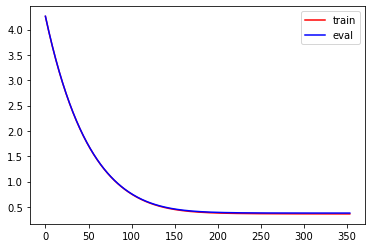

In [ ]:
#訓練データはdtrain、評価用のテストデータはdvalidと設定
watchlist = [(dtrain, 'train'), (dtest, 'eval')]
params = {
      "silent": 0,
      "max_depth": 50,
      "min_child_weight": 1,
      "eta": 0.2,
      "tree_method": "exact",
      "objective": 'reg:squarederror',
      "eval_metric": "rmse",
      # "predictor": "cpu_predictor" 
      'random_state':1234,  
  }
params["max_depth"] = trial.params["max_depth"]
params["eta"] = trial.params["eta"]
results_dict = {}
XGBmodel2 = xgb.train(params=params,
                  dtrain=dtrain,
                  num_boost_round=10000,
                  early_stopping_rounds=10,
                  evals=watchlist,
                  evals_result = results_dict,
                  )
plt.plot(results_dict["train"]["rmse"], color = "red", label = "train")
plt.plot(results_dict["eval"]["rmse"], color = "blue", label = "eval")
plt.legend()
plt.show()

##提出

In [ ]:
X_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
36021,6.850206,6.606959,6.623865,6.850206,6.606959,6.623865,6.850206,6.606959,6.623865,6.850206,6.606959,6.623865,6.850206,6.606959,6.623865
9553,3.117004,3.704907,3.632975,3.117004,3.704907,3.632975,3.117004,3.704907,3.632975,3.117004,3.704907,3.632975,3.117004,3.704907,3.632975
7222,4.532508,4.439364,4.484063,4.532508,4.439364,4.484063,4.532508,4.439364,4.484063,4.532508,4.439364,4.484063,4.532508,4.439364,4.484063
12706,4.852078,4.869195,4.821754,4.852078,4.869195,4.821754,4.852078,4.869195,4.821754,4.852078,4.869195,4.821754,4.852078,4.869195,4.821754
46235,4.012319,4.270415,4.217011,4.012319,4.270415,4.217011,4.012319,4.270415,4.217011,4.012319,4.270415,4.217011,4.012319,4.270415,4.217011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45891,5.898067,5.631376,5.786326,5.898067,5.631376,5.786326,5.898067,5.631376,5.786326,5.898067,5.631376,5.786326,5.898067,5.631376,5.786326
52416,4.963581,4.974484,5.002395,4.963581,4.974484,5.002395,4.963581,4.974484,5.002395,4.963581,4.974484,5.002395,4.963581,4.974484,5.002395
42613,4.420110,4.400017,4.309051,4.420110,4.400017,4.309051,4.420110,4.400017,4.309051,4.420110,4.400017,4.309051,4.420110,4.400017,4.309051
43567,4.294090,3.997728,4.039654,4.294090,3.997728,4.039654,4.294090,3.997728,4.039654,4.294090,3.997728,4.039654,4.294090,3.997728,4.039654


In [ ]:
test

,accommodates,bathrooms,bedrooms,beds,latitude,longitude,number_of_reviews,review_scores_rating,host_response_rate_num,Days_Int_L-F,has_Hot water,has_Pets allowed,has_Wide clearance to shower & toilet,has_Window guard,has_Private living room,has_Ethernet connection,has_Bathtub,has_Host greets you,has_Keypad,has_Hand soap,has_Pocket wifi,has_Hanger,has_Bathtub with shower chair,has_Family/kid friendly,has_Well-lit path to entrance,has_EV charger,has_Cooking basic,has_Self Check-In,has_Essential,has_Refrigerator,has_Ground floor acce,has_Air purifier,has_Wide doorway,has_Heating,has_Patio or balcony,has_Air conditioning,has_Extra pillows and blanket,has_translation missing: en.hosting_amenity_50,has_Other pet,has_Roll-in shower with chair,...,property_type_Casa particular,property_type_Castle,property_type_Cave,property_type_Chalet,property_type_Condominium,property_type_Dorm,property_type_Earth House,property_type_Guest suite,property_type_Guesthouse,property_type_Hostel,property_type_House,property_type_Hut,property_type_In-law,property_type_Island,property_type_Lighthouse,property_type_Loft,property_type_Other,property_type_Parking Space,property_type_Serviced apartment,property_type_Tent,property_type_Timeshare,property_type_Tipi,property_type_Townhouse,property_type_Train,property_type_Treehouse,property_type_Vacation home,property_type_Villa,property_type_Yurt,room_type_Private room,room_type_Shared room,response_rate_group_050,response_rate_group_5075,response_rate_group_7597,response_rate_group_97100,longitude_group_-70,longitude_group_-80,longitude_group_-90,latitude_group_38,latitude_group_41,latitude_group_42
0,6,2.0,2.0,2.0,42.359278,-71.069962,58,90.0,100.0,259.0,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,True,True,False,False,False,False,True,False,True,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1
1,3,1.0,1.0,1.0,34.084747,-118.367355,4,100.0,100.0,258.0,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,True,False,True,False,False,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,2,1.0,0.0,1.0,40.720541,-73.959192,0,96.0,100.0,425.0,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,True,False,False,False,False,True,False,True,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0
3,4,1.0,1.0,2.0,40.681117,-73.944091,0,96.0,100.0,425.0,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,True,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0
4,3,1.5,1.0,2.0,34.150995,-118.409359,6,92.0,100.0,407.0,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18523,4,1.0,2.0,2.0,40.734555,-73.954892,0,96.0,100.0,425.0,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,True,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0
18524,2,1.0,2.0,1.0,41.945939,-87.672018,9,90.0,100.0,85.0,False,False,False,False,False,False,False,False,False,False,False,F

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18528 entries, 0 to 18527
Columns: 199 entries, accommodates to latitude_group_42
dtypes: bool(128), float64(8), int64(2), uint8(61)
memory usage: 4.9 MB


In [ ]:
test_x_xgbst1=xgb.DMatrix(test)
lgb_test = lgb.Dataset(test, free_raw_data=False)
CatBoost_test = Pool(test)

test_first_preds = pd.DataFrame(np.zeros((len(test), 3*5)))#モデル数＊＊seed数

for seed in range(5):
  xgbst1 = bst.predict(test_x_xgbst1, ntree_limit=bst.best_ntree_limit)
  LGBM1=LGBM_model.predict(test, num_iteration=LGBM_model.best_iteration)
  catb1 = catb.predict(CatBoost_test)
  # # 検証データの結果
  test_first_preds.iloc[:, (seed * 3) ] =xgbst1
  test_first_preds.iloc[:, (seed * 3) + 1] = LGBM1
  test_first_preds.iloc[:, (seed * 3) + 2] = catb1


In [ ]:
#2段

# bst2_predict=bst2.predict(xgb.DMatrix(test_first_preds), ntree_limit=bst2.best_ntree_limit)
bst2_predict = XGBmodel2.predict(xgb.DMatrix(test_first_preds), ntree_limit=XGBmodel2.best_ntree_limit)
bst2_predict
len(bst2_predict)
# kaggleの課題として PassengerId 0-18527 を予測することが要求されているため
# idを生成しておく
id = np.arange(18528)

# Idと予測結果をデータフレーム化
test_result = pd.DataFrame( { 'Id': id , 'SalePrice': np.exp(bst2_predict)} )
print(test_result.head(10))

   Id   SalePrice
0   0  240.158112
1   1  132.301285
2   2   98.409416
3   3  129.768341
4   4  127.913963
5   5  151.270432
6   6  314.463898
7   7   51.549278
8   8   74.192039
9   9  769.816284


In [ ]:
# 生成したデータフレームをcsvとして保存
test_result.to_csv( '/content/drive/MyDrive/Colab Notebooks/SIGNATE/minpaku_price/results/220120-1.csv' , header=False, index=False )
# test_result.to_csv( '/content/drive/MyDrive/Colab Notebooks/SIGNATE/minpaku-price/results/210113-1.csv' , index=False )